## Optimization with Temporal and Logical Specifications via Generalized Mean-based Smooth Robustness Measures (D-GMSR)

<img src="sim/rocket_landing.gif" width="1600" align="center">

## User input

In [1]:
save_fig = True
rl_animations = False
fig_format = ['pdf', 'png']
fig_png_dpi = 600
run_list = [' ',
            'verify', 
            'plot_fcns', 
            'how_it_works', 
            'locality_masking', 
            'run_nonlinear_double_integrator', 
            'run_quadrotor_flight', 
            'run_rocket_landing',
            ]

## Libraries

In [2]:
import numpy as np
import cvxpy as cp
import sympy as sp

import os
import glob
import warnings
import typing as T
from tqdm import tqdm
from PIL import Image
from itertools import groupby, count

import matplotlib as mpl
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection

mpl.rcParams['figure.dpi'] = 120 
mpl.rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']}) ## for Palatino and other serif fonts use: #rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.prop_cycle'] = cycler(color=['tab:red', 'k', 'tab:green', 'tab:blue', 'tab:grey'])
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams.update({'font.size': 12})
mpl.rcParams.update({'legend.fontsize': 11})
mpl.rcParams.update({'axes.xmargin': 0})
mpl.rcParams.update({'lines.solid_capstyle': 'round'})
mpl.rcParams.update({'lines.solid_joinstyle': 'round'})
mpl.rcParams.update({'lines.dash_capstyle': 'round'})
mpl.rcParams.update({'lines.dash_joinstyle': 'round'})
mpl.rcParams.update({'text.latex.preamble': r"\usepackage{bm}"})

warnings.filterwarnings("ignore")

## D-SSR and D-GMSR

In [3]:
def gmsr_sympy(eps : float,
               p : int,
               weights : np.ndarray,
               N : int) -> T.Tuple[T.Any]:

    """
    :return: Functions to calculate f and A given state x
    """
        
    f = sp.zeros(2, 1)
    x = sp.Matrix(sp.symbols(['x'+str(i) for i in range(N)], real=True))
    
    fp_2 = sp.Matrix([sp.Max(0, i)**2 for i in x])
    fn_2 = sp.Matrix([sp.Min(0, i)**2 for i in x])

    fp_2p = sp.Matrix([sp.Max(0, i)**(2*p) for i in x])
    fn_2p = sp.Matrix([sp.Min(0, i)**(2*p) for i in x])
    
    M0_fp = 1
    M0_fn = 1
    
    Mp_fp = 0
    Mp_fn = 0
    
    sum_w = np.sum(weights)

    for i in range(N):
        w_i = int(weights[i])
        
        M0_fp = M0_fp * (fp_2[i]**w_i)
        M0_fn = M0_fn * (fn_2[i]**w_i)
        
        Mp_fp = Mp_fp + w_i*fp_2p[i]/sum_w
        Mp_fn = Mp_fn + w_i*fn_2p[i]/sum_w
        
    M0_fp = (eps**(sum_w) + M0_fp)**(1/sum_w)
    M0_fn = (eps**(sum_w) + M0_fn)**(1/sum_w)
    
    Mp_fp = (eps**(p) + Mp_fp)**(1/p)
    Mp_fn = (eps**(p) + Mp_fn)**(1/p)
    
    f[0, 0] = M0_fp**(1/2) - Mp_fn**(1/2) # {}^{\wedge} h_{p, w}^{\epsilon}
    f[1, 0] = Mp_fp**(1/2) - M0_fn**(1/2) # {}^{\vee}   h_{p, w}^{\epsilon}
    
    A = f.jacobian(x)

    f_func = sp.lambdify((x,), f, 'numpy')
    A_func = sp.lambdify((x,), A, 'numpy')

    return f_func, A_func

In [4]:
def ssr_sympy(k : int, 
              K : int) -> T.Tuple[T.Any]:
    """
    :return: Smooth min and max and their derivatives
    """
        
    f = sp.zeros(2, 1)
    x = sp.Matrix(sp.symbols(['x'+str(i) for i in range(K)], real=True))

    def max_aprx(x, k, K):
        sum_1 = 0.
        sum_2 = 0.
        for i in range(K):
            sum_1 = sum_1 + x[i] * sp.exp(k * x[i])
            sum_2 = sum_2 + sp.exp(k * x[i])
        return sum_1 / sum_2

    def min_aprx(x, k, K):
        sum_1 = 0.
        for i in range(K):
            sum_1 = sum_1 + sp.exp(k * -x[i])
        return -1/k * sp.log(sum_1)
    
    f[0, 0] = min_aprx(x, k, K)
    f[1, 0] = max_aprx(x, k, K)
    
    A = f.jacobian(x)

    f_func = sp.lambdify((x,), f, 'numpy')
    A_func = sp.lambdify((x,), A, 'numpy')

    return f_func, A_func

In [5]:
def gmsr_and(eps : float,
             p : int,
             weights : np.ndarray,
             *args : T.Tuple[T.Any]) -> T.Tuple[T.Any]:
    '''
    Input: The values of the functions and their gradients to be connected with And -> ( f, gf, g, gg, h, gh, ... )
    Output: gmsr_and function's value its gradient -> ( And(f,g,h, ...), And(gf, gg, gh) )
    '''
    
    K = len(args[0])
    fcn_vals = args[0]
    
    pos_idx = list(idx for idx, ele in enumerate(fcn_vals) if ele > 0.)
    neg_idx = list(idx for idx, ele in enumerate(fcn_vals) if ele <=  0.)
    
    pos_vals = fcn_vals[pos_idx]
    neg_vals = fcn_vals[neg_idx]
    
    pos_w = weights[pos_idx]
    neg_w = weights[neg_idx]
    
    sum_w = np.array(weights).sum()

    if neg_idx:
        # If there exits a negative element
        
        # Fcn Val
        sums = 0.
        for idx, neg_val in enumerate(neg_vals):
            sums = sums + neg_w[idx] * (neg_val**(2*p))
        
        Mp = (eps**(p) + (sums / sum_w))**(1/p)
        h_and = eps**(1/2) - Mp**(1/2)
        
        # Grad
        cp = 1/2 * Mp**(-1/2)
        cpm = 2*p / (p * sum_w * Mp**(p-1))
        
        c_i_w_i = np.zeros(K)
        c_i_w_i[neg_idx] = [ cp*cpm*(neg_w[idx] * (np.abs(neg_val))**(2*p-1)) for idx, neg_val in enumerate(neg_vals) ]
            
    else:
        # IF all are positive
        
        # Fcn Val
        mult = 1.
        for idx, pos_val in enumerate(pos_vals):
            mult = mult * ((pos_val)**(2*pos_w[idx]))

        M0 = (eps**(sum_w) + mult)**(1/sum_w)
        h_and = M0**(1/2) - eps**(1/2)
        
        # Grad
        c0 = 1/2 * M0**(-1/2)
        c0m = ( 2 * mult ) / ( sum_w * M0**(sum_w-1) )
                
        c_i_w_i = np.zeros(K)
        c_i_w_i[pos_idx] = [ c0*c0m*(pos_w[idx] / pos_val) for idx, pos_val in enumerate(pos_vals) ]
    
    return h_and, c_i_w_i

def gmsr_or(eps, p, weights, *args):
    '''
    Input: The values of the functions and their gradients to be connected with Or
    Output: gmsr_or function's value its gradient
    '''
    
    args = -args[0]
    h_mor, d_i_w_i = gmsr_and(eps, p, weights, args)
    return -h_mor, d_i_w_i

In [6]:
def verify_gmsr_fcn(ITE : int):

    err_arr = np.zeros(8)
    for _ in range(ITE):
    
        K = np.random.randint(10, 20)
        p = np.random.randint(1, 8)
        eps = 0.1 * np.random.rand()
        weights = np.random.randint(1, 10, size=K)

        f_func, A_func = gmsr_sympy(eps, p, weights, K)

        y = np.random.rand(K)
        h_and, h_and_grad = gmsr_and(eps, p, weights, y)
        h_or, h_or_grad = gmsr_or(eps, p, weights, y)

        err_arr[0] = (f_func(y)[0,:] - h_and).sum()
        err_arr[1] = (A_func(y)[0,:] - h_and_grad).sum()
        err_arr[2] = (f_func(y)[1,:] - h_or).sum()
        err_arr[3] = (A_func(y)[1,:] - h_or_grad).sum()

        x = y - 0.5
        h_and, h_and_grad = gmsr_and(eps, p, weights, x)
        h_or, h_or_grad = gmsr_or(eps, p, weights, x)

        err_arr[4] = (f_func(x)[0,:] - h_and).sum()
        err_arr[5] = (A_func(x)[0,:] - h_and_grad).sum()
        err_arr[6] = (f_func(x)[1,:] - h_or).sum()
        err_arr[7] = (A_func(x)[1,:] - h_or_grad).sum()

        if err_arr.sum() > 1e-8:
            print(err_arr.sum())
            print('Implementation of D-GMSR is wrong!')
            break

    print('D-GMSR - Successful')

In [7]:
def UNTIL(eps : float, 
          p : int, 
          w_f : np.ndarray, 
          w_g : np.ndarray,
          w_fg : np.ndarray, 
          f : np.ndarray,
          g : np.ndarray) -> T.Tuple[T.Any]:
    
    s = []
    ds_dg = []
    ds_df = []
    
    K = f.shape[0]
    
    for i in range(K):
        y_i, dyi_dfi = gmsr_and(eps, p, w_f[0:i+1], f[0:i+1])
        s_i, dsi_dyi__dsi_dgi = gmsr_and(eps, p, w_fg[0:2], np.array([y_i, g[i]]))

        dsi_dyi = dsi_dyi__dsi_dgi[0]
        dsi_dgi = dsi_dyi__dsi_dgi[1]
        dsi_dfi = dsi_dyi * dyi_dfi

        s.append(s_i)
        ds_dg.append(dsi_dgi)
        ds_df.append(dsi_dfi)
    
    z, dz_ds = gmsr_or(eps, p, w_g, np.array(s))
    
    dz_df = np.zeros(K)
    for i, dsi_dfi in enumerate(ds_df):
        dz_df[:i+1] += dz_ds[i] * dsi_dfi
    
    dz_dg = dz_ds * np.array(ds_dg)

    return z, dz_df, dz_dg

In [8]:
def verify_UNTIL_grads(ITE : int):

    for i in range(ITE):
        K = np.random.randint(10, 20)
        p = np.random.randint(1, 5)
        eps = 0.1 * np.random.rand()

        w_phi_1 = np.random.randint(1, 5, size=K)
        w_phi_2 = np.random.randint(1, 5, size=K)
        w_phi_12  = np.random.randint(1, 5, size=2)

        pos_neg_1 = [0., 0., -0.5, -0.5]
        pos_neg_2 = [0., -0.5, 0., -0.5]
        
        for case in range(4):

            phi_1 = np.random.rand(K) + pos_neg_1[case]
            phi_2 = np.random.rand(K) + pos_neg_2[case]
            phi_all = np.concatenate((phi_1, phi_2))

            eps_abs = 1e-8
            eps_rel = 1e-6
            del_x = np.maximum(eps_abs,eps_rel*np.abs(phi_all))  

            # Analitic Gradients
            phi_12_k, phi_1_grad, phi_2_grad = UNTIL(eps, p, w_phi_1, w_phi_2, w_phi_12, phi_1, phi_2)

            # Numerical Gradients
            grad_all = np.zeros(2*K)
            for idx in range(2*K):

                x_back = phi_all.copy()
                x_next = phi_all.copy()

                x_back[idx] -= del_x[idx]
                x_next[idx] += del_x[idx]
            
                phi_12_k1, _, _ = UNTIL(eps, p, w_phi_1, w_phi_2, w_phi_12, x_back[:K], x_back[K:])
                phi_12_k2, _, _ = UNTIL(eps, p, w_phi_1, w_phi_2, w_phi_12, x_next[:K], x_next[K:])

                grad_all[idx] = (phi_12_k2 - phi_12_k1) / (2*del_x[idx])

            err_1 = np.linalg.norm(phi_1_grad-grad_all[:K])
            err_2 = np.linalg.norm(phi_2_grad-grad_all[K:])

            if err_1 > 1e-7 or err_2 > 1e-7:
                print('Analytic gradient calculation is wrong!')
                break

    print('UNTIL - Successful')

In [9]:
def plot_fcns():
    # ---------------- GMSR (compact vectorized) ----------------
    def gmsr_and_vectorized(eps, p, weights, f, return_grad=True):
        f = np.asarray(f, float)                       # (K, ...)
        w = np.asarray(weights, float).reshape(-1)     # (K,)
        K, sw = f.shape[0], w.sum()
        wB = w.reshape((K,) + (1,)*(f.ndim-1))         # (K,1,1,...)

        neg = (f <= 0.0); pos = ~neg.any(0)            # per-point masks
        a = np.abs(f)

        Mp = (eps**p + (wB*(a**(2*p))*neg).sum(0)/sw)**(1/p)
        fpos = np.where(pos[None, ...], f, 1.0)
        mult = np.exp((2*wB*np.log(fpos)).sum(0))
        M0 = (eps**sw + mult)**(1/sw)

        h = np.where(pos, np.sqrt(M0)-np.sqrt(eps), np.sqrt(eps)-np.sqrt(Mp))
        if not return_grad: return h, None

        cp  = 0.5/np.sqrt(Mp)
        cpm = 2.0/sw if p == 1 else 2.0/(sw*Mp**(p-1))
        gneg = (cp*cpm)[None, ...] * (wB*(a**(2*p-1))*neg)

        c0  = 0.5/np.sqrt(M0)
        c0m = (2*mult)/(sw*M0**(sw-1))
        gpos = (c0*c0m)[None, ...] * (wB/fpos) * pos[None, ...]
        return h, np.where(pos[None, ...], gpos, gneg)

    def gmsr_or_vectorized(eps, p, weights, f, return_grad=True):
        h, g = gmsr_and_vectorized(eps, p, weights, -np.asarray(f, float), return_grad=return_grad)
        return -h, g

    # ---------------- Plot (compact) ----------------
    lo, hi, n = -5, 5, 401
    x = np.linspace(lo, hi, n); y = np.linspace(lo, hi, n)
    X, Y = np.meshgrid(x, y, indexing="ij")
    ix0, iy0 = np.argmin(np.abs(x)), np.argmin(np.abs(y))
    x0, y0 = x[ix0], y[iy0]
    F = np.stack([X, Y], axis=0)

    ds_pdf = 1

    clip = lambda Z: np.where((Z < lo) | (Z > hi), np.nan, Z)
    surf = lambda ax, Z, a, c: ax.plot_surface(
        X[::ds_pdf, ::ds_pdf],
        Y[::ds_pdf, ::ds_pdf],
        np.ma.masked_invalid(Z[::ds_pdf, ::ds_pdf]),
        # X, Y, np.ma.masked_invalid(Z),
        shade=False, alpha=a, color=c, linewidth=0.01, edgecolor="gray", antialiased=True
    )
    slices = lambda ax, Z, a: (
        ax.plot(np.full_like(y, x0), y, Z[ix0, :], color="#ab0e20", alpha=a, lw=1.02, ls="dashed", zorder=20),
        ax.plot(x, np.full_like(x, y0), Z[:, iy0], color="#ab0e20", alpha=a, lw=1.02, ls="dashed", zorder=20),
    )

    eps1, eps2, p = 1e-1, 4e1, 1
    w = np.array([1.0, 1.0])

    Z1_and = clip(gmsr_and_vectorized(eps1, p, w, F, return_grad=False)[0])
    Z2_and = clip(10.0*gmsr_and_vectorized(eps2, p, w, F, return_grad=False)[0])
    Z1_or  = clip(gmsr_or_vectorized (eps1, p, w, F, return_grad=False)[0])
    Z2_or  = clip(10.0*gmsr_or_vectorized (eps2, p, w, F, return_grad=False)[0])

    zmin = min(np.nanmin(Z) for Z in (Z1_and, Z2_and, Z1_or, Z2_or))
    zmax = max(np.nanmax(Z) for Z in (Z1_and, Z2_and, Z1_or, Z2_or))

    def style(ax):
        ax.set(xlim=(lo,hi), ylim=(lo,hi), zlim=(zmin,zmax), xlabel=r"$y_1$", ylabel=r"$y_2$")
        ax.set_proj_type("ortho"); ax.set_box_aspect((1,1,1))
        ax.tick_params(axis="both", labelsize=18); ax.tick_params(axis="z", labelsize=18)
        ax.grid(False)
        ax.xaxis.set_pane_color((1,1,1,1)); ax.yaxis.set_pane_color((1,1,1,1)); ax.zaxis.set_pane_color((1,1,1,0))
        ax.set_zlabel("")

    fig = plt.figure(figsize=(12, 6), constrained_layout=True); fig.patch.set_facecolor("white")

    panels = [
        ("and", Z1_and, Z2_and, (0.825, 0.981), (0.831, 0.635), (25, -75),  (5.0,  4.7, 5.2),  r"${}^{\wedge} h_{p,w}^c$"),
        ("or",  Z1_or,  Z2_or,  (1.000, 0.685), (0.735, 0.831), (20, -115), (-3.0, 4.7, 5.35), r"${}^{\vee} h_{p,w}^c$"),
    ]

    for i, (_, Z1, Z2, (a1,a2), (s1,s2), (el,az), (tx,ty,tz), title) in enumerate(panels, 1):
        ax = fig.add_subplot(1, 2, i, projection="3d"); style(ax)
        surf(ax, Z1, a1, "#acb7bb"); surf(ax, Z2, a2, "#001dac")
        slices(ax, Z1, s1); slices(ax, Z2, s2)
        ax.text(tx, ty, tz, title, fontsize=20, ha="right", va="bottom")
        ax.view_init(elev=el, azim=az)

    if save_fig: 
        for fmt in fig_format:
            fig.savefig('figs/gmsr_plots_and_or.' + fmt, bbox_inches='tight', dpi=fig_png_dpi)


## How D-GMSR works?

In [10]:
def grad_des_on_ssr_dgmsr():

    # ---------------------------------------------------------------
    # D-SSR D-GMSR Parameters
    
    K = 5
    k = 25
    p = 1
    eps = 1e-8
    weights = np.ones(K)

    f_func_smth, A_func_smth = ssr_sympy(k=k, K=K)

    # ---------------------------------------------------------------
    # Gradient Descent Parameters

    ITE = 20

    x0_and = np.array([-12., -9., -6., 3., 6.])
    alpha_and = 4.32

    x0_or = np.array([-8., -7., -6., -5.0, -4.95])
    alpha_or = 2.1

    # ---------------------------------------------------------------
    # Gradient Descent

    xk_and_1 = x0_and.copy()
    x_list_and_1 = [xk_and_1]
    f_list_and_1 = []

    xk_and_2 = x0_and.copy()
    x_list_and_2 = [xk_and_2]
    f_list_and_2 = []

    xk_or_1 = x0_or.copy()
    x_list_or_1 = [xk_or_1]
    f_list_or_1 = []

    xk_or_2 = x0_or.copy()
    x_list_or_2 = [xk_or_2]
    f_list_or_2 = []

    for i in range(ITE):
        h_and, c_i_w_i = gmsr_and(eps, p, weights, xk_and_1)
        xk_and_1 = xk_and_1 + alpha_and * c_i_w_i
        f_list_and_1.append(h_and)
        x_list_and_1.append(xk_and_1)
        
        h_and, c_i_w_i = f_func_smth(xk_and_2)[0,0], A_func_smth(xk_and_2)[0,:]
        xk_and_2 = xk_and_2 + alpha_and * c_i_w_i
        f_list_and_2.append(h_and)
        x_list_and_2.append(xk_and_2)
        
        h_or, d_i_w_i = gmsr_or(eps, p, weights, xk_or_1)
        xk_or_1 = xk_or_1 + alpha_or * d_i_w_i
        f_list_or_1.append(h_or)
        x_list_or_1.append(xk_or_1)
        
        h_or, d_i_w_i = f_func_smth(xk_or_2)[1,0], A_func_smth(xk_or_2)[1,:]
        xk_or_2 = xk_or_2 + alpha_or * d_i_w_i
        f_list_or_2.append(h_or)
        x_list_or_2.append(xk_or_2)
        
    x_list_and_1 = np.vstack(x_list_and_1)
    f_list_and_1 = np.vstack(f_list_and_1)

    x_list_and_2 = np.vstack(x_list_and_2)
    f_list_and_2 = np.vstack(f_list_and_2)

    x_list_or_1 = np.vstack(x_list_or_1)
    f_list_or_1 = np.vstack(f_list_or_1)

    x_list_or_2 = np.vstack(x_list_or_2)
    f_list_or_2 = np.vstack(f_list_or_2)

    # ---------------------------------------------------------------
    # Results - And

    fig, axs = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3, 2]}, figsize=(8, 6))

    color_1 = iter(cm.rainbow(np.linspace(0, 1, N)))
    plt.figure()
    for i in range(K):
        c = next(color_1)
        axs[0,0].plot(x_list_and_2[:, N-1-i], c=c)
    axs[0,0].axhline(0, c='black', linestyle='dashed')
    axs[0,0].set_xlabel(r'iterations', fontsize=16)
    axs[0,0].set_ylabel('$f_i(x)$', fontsize=16)
    axs[0,0].set_title('D-SSR', fontsize=16)

    color_1 = iter(cm.rainbow(np.linspace(0, 1, K)))
    plt.figure()
    for i in range(K):
        c = next(color_1)
        axs[0,1].plot(x_list_and_1[:, K-1-i], c=c)
    axs[0,1].axhline(0, c='black', linestyle='dashed')
    axs[0,1].set_xlabel(r'iterations', fontsize=16)
    axs[0,1].set_ylabel('$f_i(x)$', fontsize=16)
    axs[0,1].set_title('D-GMSR', fontsize=16)

    axs[1,0].plot(f_list_and_2, c='blue')
    axs[1,0].axhline(0, c='black', linestyle='dashed')
    axs[1,0].set_xlabel(r'iterations', fontsize=16)
    axs[1,0].set_ylabel('$\\widetilde{\\min} ( y )$', fontsize=16)

    axs[1,1].plot(f_list_and_1, c='blue')
    axs[1,1].axhline(0, c='black', linestyle='dashed')
    axs[1,1].set_xlabel(r'iterations', fontsize=16)
    axs[1,1].set_ylabel('$^{\\wedge} h_{p, w}^{\\epsilon}( y )$', fontsize=16)

    if save_fig: 
        for fmt in fig_format:
            fig.savefig('figs/and_ssr_dgmsr.' + fmt, bbox_inches='tight', dpi=fig_png_dpi)

    # ---------------------------------------------------------------
    # Results - Or

    fig, axs = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3, 2]}, figsize=(8, 6))
 
    color_1 = iter(cm.rainbow(np.linspace(0, 1, K)))
    plt.figure()
    for i in range(K):
        c = next(color_1)
        axs[0,0].plot(x_list_or_2[:, K-1-i], c=c)
    axs[0,0].axhline(0, c='black', linestyle='dashed')
    axs[0,0].set_xlabel(r'iterations', fontsize=16)
    axs[0,0].set_ylabel('$f_i(x)$', fontsize=16)
    axs[0,0].set_title('D-SSR', fontsize=16)

    color_1 = iter(cm.rainbow(np.linspace(0, 1, K)))
    plt.figure()
    for i in range(K):
        c = next(color_1)
        axs[0,1].plot(x_list_or_1[:, N-1-i], c=c)
    axs[0,1].axhline(0, c='black', linestyle='dashed')
    axs[0,1].set_xlabel(r'iterations', fontsize=16)
    axs[0,1].set_ylabel('$f_i(x)$', fontsize=16)
    axs[0,1].set_title('D-GMSR', fontsize=16)

    axs[1,0].plot(f_list_or_2, c='blue')
    axs[1,0].axhline(0, c='black', linestyle='dashed')
    axs[1,0].set_xlabel(r'iterations', fontsize=16)
    axs[1,0].set_ylabel('$$\\widetilde{\\max} ( y )$$', fontsize=14)

    axs[1,1].plot(f_list_or_1, c='blue')
    axs[1,1].axhline(0, c='black', linestyle='dashed')
    axs[1,1].set_xlabel(r'iterations', fontsize=16)
    axs[1,1].set_ylabel('$^{\\vee} h_{p, w}^{\\epsilon}(y)$', fontsize=16)

    if save_fig: 
        for fmt in fig_format:
            fig.savefig('figs/or_ssr_dgmsr.' + fmt, bbox_inches='tight', dpi=fig_png_dpi)


In [11]:
def grad_des_on_ssr_dgmsr():

    # ---------------------------------------------------------------
    # D-SSR D-GMSR Parameters
    
    K = 5
    k = 25
    p = 1
    eps = 1e-8
    weights = np.ones(K)

    f_func_smth, A_func_smth = ssr_sympy(k=k, K=K)

    # ---------------------------------------------------------------
    # Gradient Descent Parameters

    ITE = 20

    x0_and = np.array([-12., -9., -6., 3., 6.])
    alpha_and = 4.32

    x0_or = np.array([-8., -7., -6., -5.0, -4.95])
    alpha_or = 2.1

    # ---------------------------------------------------------------
    # Gradient Descent

    xk_and_1 = x0_and.copy()
    x_list_and_1 = [xk_and_1]
    f_list_and_1 = []

    xk_and_2 = x0_and.copy()
    x_list_and_2 = [xk_and_2]
    f_list_and_2 = []

    xk_or_1 = x0_or.copy()
    x_list_or_1 = [xk_or_1]
    f_list_or_1 = []

    xk_or_2 = x0_or.copy()
    x_list_or_2 = [xk_or_2]
    f_list_or_2 = []

    for i in range(ITE):
        h_and, c_i_w_i = gmsr_and(eps, p, weights, xk_and_1)
        xk_and_1 = xk_and_1 + alpha_and * c_i_w_i
        f_list_and_1.append(h_and)
        x_list_and_1.append(xk_and_1)
        
        # h_and, c_i_w_i = gmsr_and(eps, 32, weights, xk_and_2)
        h_and, c_i_w_i = f_func_smth(xk_and_2)[0,0], A_func_smth(xk_and_2)[0,:]

        xk_and_2 = xk_and_2 + alpha_and * c_i_w_i
        f_list_and_2.append(h_and)
        x_list_and_2.append(xk_and_2)
        
        h_or, d_i_w_i = gmsr_or(eps, p, weights, xk_or_1)
        xk_or_1 = xk_or_1 + alpha_or * d_i_w_i
        f_list_or_1.append(h_or)
        x_list_or_1.append(xk_or_1)
        
        h_or, d_i_w_i = f_func_smth(xk_or_2)[1,0], A_func_smth(xk_or_2)[1,:]
        xk_or_2 = xk_or_2 + alpha_or * d_i_w_i
        f_list_or_2.append(h_or)
        x_list_or_2.append(xk_or_2)
        
    x_list_and_1 = np.vstack(x_list_and_1)
    f_list_and_1 = np.vstack(f_list_and_1)

    x_list_and_2 = np.vstack(x_list_and_2)
    f_list_and_2 = np.vstack(f_list_and_2)

    x_list_or_1 = np.vstack(x_list_or_1)
    f_list_or_1 = np.vstack(f_list_or_1)

    x_list_or_2 = np.vstack(x_list_or_2)
    f_list_or_2 = np.vstack(f_list_or_2)

    # ---------------------------------------------------------------
    # Results - D-SSR

    fig, axs = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3, 2]}, figsize=(8, 6))

    color_1 = iter(cm.rainbow(np.linspace(0, 1, K)))
    plt.figure()
    for i in range(K):
        c = next(color_1)
        axs[0,0].plot(x_list_and_2[:, K-1-i], c=c)
    axs[0,0].axhline(0, c='black', linestyle='dashed')
    axs[0,0].set_xlabel(r'iterations', fontsize=16)
    axs[0,0].set_ylabel('$f_i(x_k)$', fontsize=16)
    axs[0,0].set_title('Conjunction - Always', fontsize=16)

    axs[1,0].plot(f_list_and_2, c='blue')
    axs[1,0].axhline(0, c='black', linestyle='dashed')
    axs[1,0].set_xlabel(r'iterations', fontsize=16)
    axs[1,0].set_ylabel('$\\tilde{\\rho}^{\\varphi_1 \\wedge \\varphi_2 \\wedge \\dots \\wedge \\varphi_5} (x,k)$', fontsize=16)

    color_1 = iter(cm.rainbow(np.linspace(0, 1, K)))
    plt.figure()
    for i in range(K):
        c = next(color_1)
        axs[0,1].plot(x_list_or_2[:, K-1-i], c=c)
    axs[0,1].axhline(0, c='black', linestyle='dashed')
    axs[0,1].set_xlabel(r'iterations', fontsize=16)
    axs[0,1].set_ylabel('$f_i(x_k)$', fontsize=16)
    axs[0,1].set_title('Disjunction - Eventually', fontsize=16)

    axs[1,1].plot(f_list_or_2, c='blue')
    axs[1,1].axhline(0, c='black', linestyle='dashed')
    axs[1,1].set_xlabel(r'iterations', fontsize=16)
    axs[1,1].set_ylabel('$\\tilde{\\rho}^{\\varphi_1 \\vee \\varphi_2 \\vee \\dots \\vee \\varphi_5} (x,k)$', fontsize=16)

    if save_fig: 
        for fmt in fig_format:
            fig.savefig('figs/dssr.' + fmt, bbox_inches='tight', dpi=fig_png_dpi)

    # ---------------------------------------------------------------
    # Results - D-GMSR

    fig, axs = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3, 2]}, figsize=(8, 6))

    color_1 = iter(cm.rainbow(np.linspace(0, 1, K)))
    plt.figure()
    for i in range(K):
        c = next(color_1)
        axs[0,0].plot(x_list_and_1[:, K-1-i], c=c)
    axs[0,0].axhline(0, c='black', linestyle='dashed')
    axs[0,0].set_xlabel(r'iterations', fontsize=16)
    axs[0,0].set_ylabel('$f_i(x_k)$', fontsize=16)
    axs[0,0].set_title('Conjunction - Always', fontsize=16)

    axs[1,0].plot(f_list_and_1, c='blue')
    axs[1,0].axhline(0, c='black', linestyle='dashed')
    axs[1,0].set_xlabel(r'iterations', fontsize=16)
    axs[1,0].set_ylabel('$\\Gamma^{\\varphi_1 \\wedge \\varphi_2 \\wedge \\dots \\wedge \\varphi_5}_{\\bm{\\epsilon}, \\bm{p}, \\bm{w}} (x,k)$', fontsize=16)

    color_1 = iter(cm.rainbow(np.linspace(0, 1, K)))
    plt.figure()
    for i in range(K):
        c = next(color_1)
        axs[0,1].plot(x_list_or_1[:, K-1-i], c=c)
    axs[0,1].axhline(0, c='black', linestyle='dashed')
    axs[0,1].set_xlabel(r'iterations', fontsize=16)
    axs[0,1].set_ylabel('$f_i(x_k)$', fontsize=16)
    axs[0,1].set_title('Disjunction - Eventually', fontsize=16)
 
    axs[1,1].plot(f_list_or_1, c='blue')
    axs[1,1].axhline(0, c='black', linestyle='dashed')
    axs[1,1].set_xlabel(r'iterations', fontsize=16)
    axs[1,1].set_ylabel('$\\Gamma^{\\varphi_1 \\vee \\varphi_2 \\vee \\dots \\vee \\varphi_5}_{\\bm{\\epsilon}, \\bm{p}, \\bm{w}} (x,k)$', fontsize=16)

    if save_fig: 
        for fmt in fig_format:
            fig.savefig('figs/dgmsr.' + fmt, bbox_inches='tight', dpi=fig_png_dpi)


## Locality & Masking

In [12]:
def lm_params_fcn():
    params = dict()

    # Problem
    params['K'] = 9
    params['wp'] = np.array([[1.25], [-3], [0.2]])

    # STL
    params['stl_eps'] = 1e-8
    params['stl_p'] = 1
    params['stl_w'] = np.ones(params['K'])
    params['f_func_ssr'], params['A_func_ssr'] = ssr_sympy(k=25, K=params['K'])

    # Prox-linear
    params['N_ite'] = 10
    params['w_tr0'] = 0.8
    params['r0'] = 0.01
    params['r1'] = 0.1
    params['r2'] = 0.9
    params['adaptive_step'] = True

    return params
    
def RUN_LM(params):

    def f_wp_evnt(xk, uk, dx, du, params, npy=True):

        dist_n = -(-params['wp'][2, 0]+np.linalg.norm(xk - params['wp'][:2, :], axis=0))
        if params['stl_type'] == 'D-SSR':
            f0, g1 = params['f_func_ssr'](dist_n)[1:, :], params['A_func_ssr'](dist_n)[1, :]
        elif params['stl_type'] == 'D-GMSR':
            f0, g1 = gmsr_or(params['stl_eps'], params['stl_p'], params['stl_w'], dist_n)
        
        direction = -(xk - params['wp'][:2, :]) / dist_n
        g2 = -(np.diag(g1) @ direction.T).T
        if not(npy):
            lin = ( f0 + cp.sum(cp.multiply(g2, dx)) )
        else:
            lin = ( f0 + (g2 * dx).sum() )
            
        return -f0, -lin

    def f_ptr(dx, du, npy=True):
        if npy:
            return np.sum((np.linalg.norm(dx, axis=0))**2) + np.sum((np.linalg.norm(du, axis=0))**2)
        else:
            return cp.sum((cp.norm(dx, axis=0))**2) + cp.sum((cp.norm(du, axis=0))**2)
        
    def solve_cvx(X, U, w_tr, params):
        
        dX = cp.Variable((2, params['K']))
        dU = cp.Variable((2, params['K'] - 1))
        
        _, lin = f_wp_evnt(X, U, dX, dU, params, npy=False)
        
        mdl_obj = cp.Minimize( lin )
        ptr_obj = cp.Minimize( w_tr * f_ptr(dX, dU, npy=False) )
        
        obj = mdl_obj + ptr_obj
        cons = [ 
                (X + dX)[:, 1:] == (X + dX)[:, 0:-1] + (U + dU),
                (X + dX)[:, 0] == np.array([0., 0.]),
                (X + dX)[:, -1] == np.array([8., 0.]),
                cp.norm(U + dU, axis=0) <= 1.5,
            ]

        problem = cp.Problem(obj, cons)
        
        try:
            problem.solve(solver='ECOS')
        except:
            problem.solve(solver='MOSEK')

        return dX.value, dU.value, ptr_obj.value
        
    def prox_linear(params):

        w_tr = params['w_tr0']

        Xk = np.zeros((2, params['K']))
        Uk = np.zeros((2, params['K']-1))

        Xk[0, :] = np.arange(0, params['K'], 1)
        Uk[0, :] = np.ones(params['K']-1)

        nl0, _ = f_wp_evnt(Xk, Uk, Xk-Xk, Uk-Uk, params, npy=True)
        f_list = [nl0]
        x_list = [Xk]

        for i in range(params['N_ite']):
            while True:

                dX, dU, ptr_val = solve_cvx(Xk, Uk, w_tr, params)

                _, lf  = f_wp_evnt(Xk, Uk, dX,  dU,  params, npy=True)
                nl0, _ = f_wp_evnt(Xk, Uk, Xk-Xk, Uk-Uk, params, npy=True)
                nl1, _ = f_wp_evnt(Xk+dX, Uk+dU, Xk-Xk,  Uk-Uk, params, npy=True)

                if params['adaptive_step']:

                    act_chg = nl0 - nl1
                    prd_chg = nl0 - lf

                    rho = act_chg / (prd_chg - ptr_val)

                    if rho < params['r0']:
                        w_tr *= 2.0
                    else:

                        Xk = Xk + dX
                        Uk = Uk + dU

                        f_list.append(nl1)
                        x_list.append(Xk)

                        if params['r2'] <= rho:
                            w_tr /= 2.0
                            w_tr = np.maximum(w_tr, 0.1)

                        break
                else:
                    Xk = Xk + dX
                    Uk = Uk + dU

                    f_list.append(nl1)
                    x_list.append(Xk)
                    break

        f_list = -np.vstack(f_list)
        x_list = (np.vstack(x_list)).reshape(-1, 2, params['K'])
        
        return f_list, x_list

    def plot(params, results):
        fig, axs = plt.subplots(nrows=3, ncols=2, gridspec_kw={'height_ratios': [5, 3, 2]}, figsize=(8, 8))

        gs = axs[0, 0].get_gridspec()
        for ax in axs[0, :]:
            ax.remove()
        axa = fig.add_subplot(gs[0, :])
            
        circle = plt.Circle((params['wp'][0,0], params['wp'][1,0]), params['wp'][2,0], color='blue', clip_on=False, fill=False)
        axa.add_patch(circle)

        cc = plt.cm.rainbow(np.linspace(0, 1, params['K']))

        axa.plot(results['x_dgmsr'][0,0,:], 
                 results['x_dgmsr'][0,1,:], 
                 c='black', label='Initial Trajectory', linestyle='dotted')
        axa.scatter(results['x_dgmsr'][0,0,:], 
                    results['x_dgmsr'][0,1,:], 
                    c = cc, alpha = 1, s=50, zorder=10)

        axa.plot(results['x_ssr'][-1,0,:], 
                 results['x_ssr'][-1,1,:], 
                 c='red', label='D-SSR', linestyle='dotted')
        axa.scatter(results['x_ssr'][-1,0,:], 
                    results['x_ssr'][-1,1,:], 
                    c = cc, alpha = 1, s=50, zorder=10)
        
        axa.plot(results['x_dgmsr'][-1,0,:], 
                 results['x_dgmsr'][-1,1,:], 
                 c='blue', label='D-GMSR', linestyle='dotted')
        axa.scatter(results['x_dgmsr'][-1,0,:], 
                    results['x_dgmsr'][-1,1,:], 
                    c = cc, alpha = 1, s=50, zorder=10)
            
        axa.set_aspect('equal')
        axa.set_title('Position [m]', fontsize=16)   
        axa.legend(prop={'size': 14})

        color_1 = iter(cm.rainbow(np.linspace(0, 1, params['K'])))
        plt.figure()
        for i in range(params['K']):
            c = next(color_1)
            all_dist = -(-params['wp'][2, 0]+np.linalg.norm(results['x_ssr'][:,:,i].T - params['wp'][:2, :], axis=0))
            axs[1,0].plot(all_dist, c=c)
        axs[1,0].axhline(0, c='black', linestyle='dashed')
        axs[1,0].set_xlabel(r'iterations', fontsize=16)
        axs[1,0].set_ylabel('$f(x_k)$', fontsize=16)
        axs[1,0].set_title('D-SSR', fontsize=16)

        axs[2,0].plot(results['f_ssr'], c='blue')
        axs[2,0].axhline(0, c='black', linestyle='dashed')
        axs[2,0].set_xlabel(r'iterations', fontsize=16)
        axs[2,0].set_ylabel('$$\\tilde{\\rho}^{ \\bm{F}_{[1:K]} \\varphi} (x,0)$$', fontsize=16)

        color_1 = iter(cm.rainbow(np.linspace(0, 1, params['K'])))
        for i in range(params['K']):
            c = next(color_1)
            all_dist = -(-params['wp'][2, 0]+np.linalg.norm(results['x_dgmsr'][:,:,i].T - params['wp'][:2, :], axis=0))
            axs[1,1].plot(all_dist, c=c)
        axs[1,1].axhline(0, c='black', linestyle='dashed')
        axs[1,1].set_xlabel(r'iterations', fontsize=16)
        axs[1,1].set_ylabel('$f(x_k)$', fontsize=16)
        axs[1,1].set_title('D-GMSR', fontsize=16)

        axs[2,1].plot(results['f_dgmsr'], c='blue')
        axs[2,1].axhline(0, c='black', linestyle='dashed')
        axs[2,1].set_xlabel(r'iterations', fontsize=16)
        axs[2,1].set_ylabel('$\\Gamma^{ \\bm{F}_{[1:K]} \\varphi}_{\\bm{\\epsilon}, \\bm{p}, \\bm{w}} (x,0)$', fontsize=16)

        if save_fig: 
            for fmt in fig_format:
                fig.savefig('figs/locality_masking.' + fmt, bbox_inches='tight', dpi=fig_png_dpi)

    results = dict()

    params['stl_type'] = 'D-SSR'
    results['f_ssr'], results['x_ssr'] = prox_linear(params)

    params['stl_type'] = 'D-GMSR'
    results['f_dgmsr'], results['x_dgmsr'] = prox_linear(params)

    plot(params, results)

## Successive Convexification for Trajectory Optimization

### Integration

In [13]:
def rk4(func : T.Any,
        y0 : np.ndarray, 
        tf : float, 
        steps : int, 
        *args : T.Tuple[T.Any]) -> np.ndarray:
    """
    Implementation of the fourth-order Runge-Kutta (RK4) method for numerical integration.

    Parameters:
    - f: Function representing the system of ordinary differential equations (ODEs).
    - y0: Initial conditions (numpy array, n-dimensional column vector).
    - t: Time points for which the solution is calculated.

    Returns:
    - y: Solution of the ODEs at each time point.
    """

    t = np.linspace(0, tf, int(steps))  # Time points

    # Ensure y0 is a NumPy array (n-dimensional column vector)
    # y0 = np.array(y0).reshape(-1, 1)
    y0 = y0.reshape(-1, 1)

    # Initialize solution array
    y = np.zeros((len(t), len(y0)))
    y[0, :] = y0.flatten()

    # Perform RK4 integration
    for i in range(len(t) - 1):

        h = t[i + 1] - t[i]
        k1 = h * func(y[i], t[i], args)
        k2 = h * func(y[i] + 0.5 * k1, t[i] + 0.5 * h, args)
        k3 = h * func(y[i] + 0.5 * k2, t[i] + 0.5 * h, args)
        k4 = h * func(y[i] + k3, t[i] + h, args)

        y[i + 1, :] = y[i, :] + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return y

In [14]:
def dxdt(x : np.ndarray,
         t : float, 
         *args : T.Tuple[T.Any],
        ) -> np.ndarray:

    """
    return: x_dot(t)
    """

    tt, tf, u_0 , u_1, params = args[0]
    
    if params['inp_param'] == 'FOH':
        u = u_0 + (t / tf) * (u_1 - u_0)
    elif params['inp_param'] == 'ZOH':
        u = u_0.copy()
    
    return params['f_func'](x, u)[:, 0]

def integrate_dynamics(x : np.ndarray,
                       u_0 : np.ndarray,
                       u_1 : np.ndarray,
                       params : T.Dict[str, T.Any],
                       tf : float,
                       tt : float,
                      ) -> T.Tuple[np.ndarray]:
    """
    Integration of the vehicle dynamics [0, tf]
    return: x[t+dt] and u
    """
    x_next = rk4(dxdt, x, tf, params['rk4_steps_dyn'], tt, tf, u_0, u_1, params)[-1,:]
    return x_next

def integrate_multiple(X, U, params):
    
    x_k1_list = []
    for k in range(X.shape[1] - 1):
        tt = k * params['t_scp']
        x_k1 = integrate_dynamics(X[:, k], U[:, k], U[:, k+1], params, params['t_scp'], tt)
        x_k1_list.append(x_k1)
        
    return (np.vstack(x_k1_list)).T

### Discretization

In [15]:
def dVdt(V : np.ndarray, 
         t : float, 
         *args : T.Tuple[T.Any],
        ) -> np.ndarray:
    """
    ODE function to compute dVdt.
    V: Evaluation state V = [x, Phi_A, B_bar, C_bar, z_bar]
    t: Evaluation time
    u: Input at start of interval
    return: Derivative at current time and state dVdt
    """

    args = args[0]
    u_0, u_1, tt, params = args

    n_x = params['n_states']
    n_u = params['n_controls']
    
    i0 = 0
    i1 = n_x
    i2 = i1 + n_x*n_x
    i3 = i2 + n_x*n_u
    i4 = i3 + n_x*n_u
    i5 = i4 + n_x
    
    x = V[i0:i1]
    p = np.zeros(1)

    if params['inp_param'] == 'ZOH':
        beta = 0.
    elif params['inp_param'] == 'FOH':
        beta = t / params['t_scp']
    alpha = 1 - beta
    
    u = u_0 + beta * (u_1 - u_0)

    A_subs = params['A_func'](x, u)
    B_subs = params['B_func'](x, u)
    f_subs = params['f_func'](x, u)[:, 0]
    
    z_t = np.squeeze(f_subs) - np.matmul(A_subs, x) - np.matmul(B_subs, u)
    
    dVdt = np.zeros_like(V)
    dVdt[i0:i1] = f_subs.T
    dVdt[i1:i2] = np.matmul(A_subs, V[i1:i2].reshape((n_x, n_x))).reshape(-1)
    dVdt[i2:i3] = (np.matmul(A_subs, V[i2:i3].reshape((n_x, n_u))) + B_subs * alpha).reshape(-1)
    dVdt[i3:i4] = (np.matmul(A_subs, V[i3:i4].reshape((n_x, n_u))) + B_subs * beta).reshape(-1)
    dVdt[i4:i5] = (np.matmul(A_subs, V[i4:i5]).reshape(-1) + z_t)

    return dVdt

def calculate_discretization(X : np.ndarray, 
                             U : np.ndarray, 
                             params : T.Dict[str, T.Any],
                            ) -> T.Dict[str, T.Any]:
    """
    Calculate discretization for given states, inputs and total time.
    X: Matrix of states for all time points
    U: Matrix of inputs for all time points
    return: The discretization matrices
    """
    
    n_x = params['n_states']
    n_u = params['n_controls']
    
    i0 = 0
    i1 = n_x
    i2 = i1 + n_x*n_x
    i3 = i2 + n_x*n_u
    i4 = i3 + n_x*n_u
    i5 = i4 + n_x
    
    V0 = np.zeros(i5)
    V0[i1:i2] = np.eye(n_x).reshape(-1)

    f_bar = np.zeros((n_x, params['K']-1))
    A_bar = np.zeros((n_x * n_x, params['K']-1))
    B_bar = np.zeros((n_x * n_u, params['K']-1))
    C_bar = np.zeros((n_x * n_u, params['K']-1))
    z_bar = np.zeros((n_x, params['K']-1))

    for k in range(params['K'] - 1):
        V0[i0:i1] = X[:, k]

        tt = k*params['t_scp']
        V = rk4(dVdt, V0, params['t_scp'], params['rk4_steps_J'], U[:, k], U[:, k+1], tt, params)[-1,:]

        # flatten matrices in column-major (Fortran) order for cvxpy
        f_bar[:, k] = V[i0:i1]
        Phi = V[i1:i2].reshape((n_x, n_x))
        A_bar[:, k] = Phi.flatten(order='F')
        B_bar[:, k] = (V[i2:i3].reshape((n_x, n_u))).flatten(order='F')
        C_bar[:, k] = (V[i3:i4].reshape((n_x, n_u))).flatten(order='F')
        z_bar[:, k] = (V[i4:i5])

    params['f_bar'] = f_bar
    params['A_bar'] = A_bar
    params['B_bar'] = B_bar
    params['C_bar'] = C_bar
    params['z_bar'] = z_bar
    
    return params

### Linear / Nonlinear Cost

In [16]:
def scp_non_linear_cost(X_new : np.ndarray,
                        U_new : np.ndarray,
                        X_last : np.ndarray,
                        U_last : np.ndarray,
                        nu_new : np.ndarray,
                        nl_nu_new : np.ndarray,
                        w_tr : float,
                        params : T.Dict[str, T.Any],
                       ) -> T.Tuple[np.ndarray]:
    """
    Returns the nonlinear or linearized cost value of the SCP problem
    Required for prox-linear with adaptive step-size
    """

    cost_dict = dict()

    cost_dict['ptr_cost'] = w_tr * (np.linalg.norm(X_new -  X_last, axis=0)**2 + np.linalg.norm(U_new -  U_last, axis=0)**2).sum()

    cost_dict['lin_cost'] = cost_dict['ptr_cost']
    cost_dict['n_lin_cost'] = cost_dict['ptr_cost']
    
    cost_dict['lin_vehicle_cost'] = params['vehicle_cost_fcn'](X_new, U_new, X_last, U_last, params, npy=True)
    cost_dict['n_lin_vehicle_cost'] = params['vehicle_cost_fcn'](X_new, U_new, X_new, U_new, params, npy=True)
    
    cost_dict['lin_cost'] += cost_dict['lin_vehicle_cost']
    cost_dict['n_lin_cost'] += cost_dict['n_lin_vehicle_cost']

    cost_dict['lin_dyn_cost'] = params['w_con_dyn'] * np.linalg.norm(nu_new.reshape(-1), 1)
    cost_dict['n_lin_dyn_cost'] = params['w_con_dyn'] * np.linalg.norm(nl_nu_new.reshape(-1), 1)

    cost_dict['lin_cost'] += cost_dict['lin_dyn_cost']
    cost_dict['n_lin_cost'] += cost_dict['n_lin_dyn_cost']
        
    return cost_dict

### Convex Problem (sub-problem)

In [17]:
def solve_convex_problem(X_last : np.ndarray,
                         U_last : np.ndarray,
                         w_tr : float,
                         params : T.Dict[str, T.Any],
                        ) -> T.Tuple[np.ndarray]:
       
    """
    Solves the convex sub-problem using QOCO (or ECOS or MOSEK) and retruns the optimal values of X and U
    """
    
    X  = cp.Variable((params['n_states'],   params['K']))
    U  = cp.Variable((params['n_controls'], params['K']))
    nu = cp.Variable((params['n_states'],   params['K']-1))

    cost = w_tr * (cp.sum(cp.norm(X - X_last, axis=0)**2) + cp.sum(cp.norm(U - U_last, axis=0)**2)) # Trust region
    cost += params['w_con_dyn'] * cp.sum(cp.abs(nu))

    constraints = [
        X[:, k + 1] ==
        cp.reshape(params['A_bar'][:, k], (params['n_states'], params['n_states'])) @ X[:, k]
        + cp.reshape(params['B_bar'][:, k], (params['n_states'], params['n_controls'])) @ U[:, k]
        + cp.reshape(params['C_bar'][:, k], (params['n_states'], params['n_controls'])) @ U[:, k+1]
        + params['z_bar'][:, k]
        + nu[:, k]
        for k in range(params['K'] - 1)
    ]
    
    cost += params['vehicle_cost_fcn'](X, U, X_last, U_last, params, npy=False)
    constraints += params['vehicle_cons_fcn'](X, U, X_last, U_last, params, npy=False)
    
    # Create the optimization problem
    problem = cp.Problem(cp.Minimize(cost), constraints)

    # Solve the optimization problem
    try:
        problem.solve(solver='QOCO')
    except:
        try:
            problem.solve(solver='ECOS')
        except:
            problem.solve(solver='MOSEK')
    
    return X.value, U.value, nu.value

### Prox-linear

In [18]:
def prox_linear(params : T.Dict[str, T.Any],
               ) -> T.Dict[str, T.Any]:

    """
    Solves the non-convex trajectory optimization problem using Penalized Trust Region method (PTR)
    """
        
    X_last = params['X_last']
    U_last = params['U_last']
    w_tr = params['w_ptr']
    last_cost = None
    
    prox_results = dict()
    prox_results['ptr_cost_list'] = []
    prox_results['non_lin_cost_list'] = []
    prox_results['dynamical_cost_list'] = []
    prox_results['vehicle_cost_list'] = []
    prox_results['w_tr_list'] = []

    for i in range(params['ite']):
        if params['print_ite_number']:
            print('-'*50)
            print('ite: ', i)
            print('-'*50)
            print(' ')
        params = calculate_discretization(X_last, U_last, params)
        while True:
            if w_tr > 1e8: break
                
            X_new, U_new, nu_new = solve_convex_problem(X_last, U_last, w_tr, params)

            X_nl = X_new.copy()
            X_nl[:, 1:] = integrate_multiple(X_new, U_new, params)

            cost_dict = scp_non_linear_cost(X_new, U_new,  X_last, U_last, nu_new, (X_new - X_nl),  w_tr, params)
                
            if not(last_cost) or not(params['adaptive_step']):
                X_last = X_new.copy()
                U_last = U_new.copy()
                last_cost = cost_dict['n_lin_cost']
                
                prox_results['ptr_cost_list'].append(cost_dict['ptr_cost'])
                prox_results['non_lin_cost_list'].append(cost_dict['n_lin_cost'])
                prox_results['dynamical_cost_list'].append(np.sum(np.linalg.norm((X_new - X_nl)[:, :], axis=1, ord=1)))
                prox_results['vehicle_cost_list'].append(cost_dict['n_lin_vehicle_cost'])
                prox_results['w_tr_list'].append(w_tr)
                break

            else:
                delta_J = last_cost - cost_dict['n_lin_cost']
                delta_L = last_cost - cost_dict['lin_cost']

                rho = delta_J / delta_L
                if rho <= params['r0']:
                    w_tr = w_tr * 2

                else:
                    X_last = X_new.copy()
                    U_last = U_new.copy()
                    last_cost = cost_dict['n_lin_cost']
                    
                    prox_results['ptr_cost_list'].append(cost_dict['ptr_cost'])
                    prox_results['non_lin_cost_list'].append(cost_dict['n_lin_cost'])
                    prox_results['dynamical_cost_list'].append(np.sum(np.linalg.norm((X_new - X_nl)[:, :], axis=1, ord=1)))
                    prox_results['vehicle_cost_list'].append(cost_dict['n_lin_vehicle_cost'])
                    prox_results['w_tr_list'].append(w_tr)

                    if params['r2'] <= rho:
                        w_tr = np.maximum(w_tr / 2, params['w_ptr_min'])
                    break
    
    prox_results['X_new'] = X_last
    prox_results['U_new'] = U_last

    return prox_results

### Plot cost

In [19]:
def plot_cost(results, params, vehicle):
    
    fig, (ax0, ax1, ax2) = plt.subplots(figsize=(6, 6), nrows=3, sharex=True)

    ax0.plot(results['dynamical_cost_list_all'][0,:])
    ax0.set_xlabel(r'iterations', fontsize=12)
    ax0.set_ylabel('Dynamical Cost', fontsize=12)
    ax0.set_yscale('log')

    fuel_cost = 0.
    if vehicle == 'rl':
        fuel_cost = params['w_obj_fuel'] * results['x_nmpc_all'][0, -1, 0] / params['tm_sc']
    
    ax1.plot( results['vehicle_cost_list_all'][0, :] + fuel_cost )

    ax1.set_xlabel(r'iterations', fontsize=12)
    ax1.set_ylabel(r'STL Cost', fontsize=12)

    ax2.plot(results['w_tr_list_all'][0,:])
    ax2.set_xlabel(r'iterations', fontsize=12)
    ax2.set_ylabel(r'TR Weight', fontsize=12)

    print('Dynamical Cost', results['dynamical_cost_list_all'][0,-1])
    print('STL Cost', results['vehicle_cost_list_all'][0,-1] + fuel_cost)
    print('TR Weight', results['w_tr_list_all'][0,-1])

### Gif maker

In [20]:
def make_gif(frame_folder):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*"+".png"))][::2]
    frame_one = frames[0]
    frame_one.save(frame_folder+"/"+ "animation.gif", format="GIF", 
                   append_images=frames, save_all=True, duration=0.1, loop=0)

### RUN

In [21]:
def RUN(params : T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    x_all = [params['x_init']]
    u_all = []

    prox_results = prox_linear(params)
    
    x_next = params['x_init'].copy()
    times = np.arange(0, params['t_f']+params['dt'], params['dt'])
    for i_int in tqdm(range(len(times)-1)):
        params['t_curr'] = times[i_int]
        idx = int(params['t_curr'] / params['t_scp'])

        if params['inp_param'] == 'ZOH':
            u_0 = prox_results['U_new'][:, idx]
            u_1 = prox_results['U_new'][:, idx]
            
        elif params['inp_param'] == 'FOH':
            t0_scp = (params['t_curr']+1e-6) % (params['t_scp'])

            beta = t0_scp/params['t_scp']
            
            u_0 = prox_results['U_new'][:, idx] + beta * (prox_results['U_new'][:, idx+1] - prox_results['U_new'][:, idx])
            
            beta = (t0_scp+params['dt'])/params['t_scp']
            u_1 = prox_results['U_new'][:, idx] + beta * (prox_results['U_new'][:, idx+1] - prox_results['U_new'][:, idx])
            
        x_next = integrate_dynamics(x_next, u_0, u_1, params, params['dt'], tt=0)
        x_all.append(x_next)
        u_all.append(np.vstack((u_0, u_1)))

    scp_results = dict()
    scp_results['times'] = times

    scp_results['x_all'] = np.vstack(x_all)
    scp_results['u_all'] = np.dstack(u_all)
    scp_results['x_nmpc_all'] = np.dstack(prox_results['X_new'])
    scp_results['u_nmpc_all'] = np.dstack(prox_results['U_new'])

    scp_results['ptr_cost_list_all'] = np.array([prox_results['ptr_cost_list']])
    scp_results['non_lin_cost_list_all'] = np.array([prox_results['non_lin_cost_list']])
    scp_results['dynamical_cost_list_all'] = np.array([prox_results['dynamical_cost_list']])
    scp_results['vehicle_cost_list_all'] = np.array([prox_results['vehicle_cost_list']])
    scp_results['w_tr_list_all'] = np.array([prox_results['w_tr_list']])

    return scp_results

## (1/3) Non-linear Double Integrator

### Parameters

In [22]:
def ndi_params_fcn() -> T.Dict[str, T.Any]:

    """
    Static parameters for the scenario
    """

    t_f = 8.0  # Total simulation time [s]
    K = 17 # Total number of nodes
    t_scp = t_f / (K-1)

    n_states = 4 # p_x, p_y, v_x, v_y
    n_controls = 2 # a_x, a_y

    x_init  = np.array([0., 0., 0., 0.])  # [x, y, x_dot, y_dot]
    x_final = np.array([8., 0., 0., 0.])  # [x, y, x_dot, y_dot]

    X_last = np.zeros((n_states, K))
    U_last = np.zeros((n_controls, K))
    X_last[0, :] = np.linspace(x_init[0], x_final[0], K)

    return dict(
        # ---------------------------------------------------------------------------------------------------

        # General Parameters
        t_f = t_f,
        K = K,
        t_scp = t_scp,
        dt = t_scp,

        n_states = n_states,
        n_controls = n_controls,
        inp_param = 'FOH',

        x_init  = x_init,
        x_final = x_final,

        X_last = X_last,
        U_last = U_last,
                
        vehicle_v_max = 2.0, # [m/s]
        vehicle_v_max_evnt = 1.0, # [m/s]
        vehicle_a_max = 1.5, # [m/s^2]
        cd = 0.01,

        # ---------------------------------------------------------------------------------------------------

        # Prox-linear Parameters
        ite = 20, # Total number of iterations for the prox-linear algorithm
        w_obj_stl = 1., # Penalization weight for the actual cost
        w_con_dyn = 1e3, # Penalization weight for the constraints
        
        # Prox-linear via adaptive step-size
        adaptive_step = True, # Updates the penalization cost of prox-linear
        w_ptr = 1e-2, # Initial penaliztion weight for the trust-regrion
        w_ptr_min = 0.001, # Minimum penaliztion weight for the trust-regrion
        r0 = 0.01, # Minimum linearization accuracy to accept the SCP iteration and increase w_ptr
        r1 = 0.1, # Minimum linearization accuracy to use the same w_ptr
        r2 = 0.9, # Minimum linearization accuracy to decrease the w_ptr

        # ---------------------------------------------------------------------------------------------------

        # STL
        stl_eps = 1e-8,
        stl_p = 1,
        stl_w_phi_1 = np.ones(K),
        stl_w_phi_2 = np.ones(K),
        stl_w_phi_12 = np.ones(2),
        p_w = np.array([[1.25], [-2.], [0.2]]), # Way-point
        
        # ---------------------------------------------------------------------------------------------------

        # Integration
        rk4_steps_dyn = 5,
        rk4_steps_J = 5,

        # ---------------------------------------------------------------------------------------------------

        print_ite_number = False,
    )

### Objective and Constraint Functions

In [23]:
def ndi_f_wp(xk : np.ndarray, 
             dx : np.ndarray,
             p_w : np.ndarray,
             npy : bool) -> T.Tuple[T.Any]:
    
    dist_c = np.linalg.norm(xk[:2, :] - p_w[:2, :], axis=0)
    dist = (p_w[2, 0]-dist_c)
    direction = -(xk[:2, :] - p_w[:2, :]) / (dist_c + 1e-8)
    
    f_0 = dist
    if not(npy):
        l_k = ( f_0 + cp.sum(cp.multiply(direction, dx[:2, :]), axis=0) )
    else:
        l_k = ( f_0 + (direction * dx[:2, :]).sum(axis=0) )
        
    return f_0, l_k

def ndi_f_spd(xk : np.ndarray,
              dx : np.ndarray,
              spd_lim : np.ndarray,
              npy : bool) -> T.Tuple[T.Any]:
    
    speed = np.linalg.norm(xk[2:4, :], axis=0)
    dist = (spd_lim-speed)
    direction = -(xk[2:4, :]) / (speed + 1e-8)
    
    f_0 = dist
    if not(npy):
        l_k = ( f_0 + cp.sum(cp.multiply(direction, dx[2:4, :]), axis=0) )
    else:
        l_k = ( f_0 + (direction * dx[2:4, :]).sum(axis=0) )
        
    return f_0, l_k

def ndi_f_until(xk : np.ndarray,
                dxk : np.ndarray,
                params : T.Dict,
                npy : bool=True) -> T.Tuple[T.Any]:
    
    # ---------------------------------------------------
    f_0_wp, l_k_wp = ndi_f_wp(xk=xk, 
                              dx=dxk,
                              p_w=params['p_w'],
                              npy=npy)
    # ---------------------------------------------------
    f_0_spd, l_k_spd = ndi_f_spd(xk=xk,
                                 dx=dxk,
                                 spd_lim=params['vehicle_v_max_evnt'], 
                                 npy=npy)
        
    # ---------------------------------------------------
    f_0_until, phi_1_grad, phi_2_grad = UNTIL(params['stl_eps'], 
                                              params['stl_p'],
                                              params['stl_w_phi_1'], 
                                              params['stl_w_phi_2'], 
                                              params['stl_w_phi_12'], 
                                              f_0_spd, 
                                              f_0_wp)
    # ---------------------------------------------------

    if npy:
        l_k_until = f_0_until + np.sum(phi_2_grad*(l_k_wp-f_0_wp) + phi_1_grad*(l_k_spd-f_0_spd))
    else:
        l_k_until = f_0_until + cp.sum(phi_2_grad*(l_k_wp-f_0_wp) + phi_1_grad*(l_k_spd-f_0_spd))

    return -f_0_until, -l_k_until

### Vehcile Dynamics

In [24]:
def ndi_dynamics(params: T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    def f(x,u):
        speed = (x[2]**2+x[3]**2)**(0.5)
        return np.array([[x[2]], 
                         [x[3]], 
                         [u[0] - params['cd'] * x[2] * speed], 
                         [u[1] - params['cd'] * x[3] * speed], 
                        ])

    def A(x,u):
        speed = (x[2]**2+x[3]**2 + 1e-6)**(0.5)
        return np.array([[0, 0, 1, 0],
                         [0, 0, 0, 1],
                         [0, 0, -params['cd'] * (speed + x[2]*x[2] / speed), -params['cd'] * (        x[2]*x[3] / speed)],
                         [0, 0, -params['cd'] * (        x[2]*x[3] / speed), -params['cd'] * (speed + x[3]*x[3] / speed)],
                        ])
        
    def B(x,u):
        return np.array([[0, 0], 
                         [0, 0],
                         [1, 0], 
                         [0, 1]])

    params['f_func'] = f
    params['A_func'] = A
    params['B_func'] = B

    return params

### Vehicle Constraints

In [25]:
def ndi_cost_fcn(X : np.ndarray,
                 U : np.ndarray,
                 X_last : np.ndarray,
                 U_last : np.ndarray,
                 params : T.Dict[str, T.Any],
                 npy : bool,
                 ) -> T.Tuple[T.Any]:
    
    _, lin_until_cost = ndi_f_until(X_last, X - X_last, params, npy=npy)
    vehicle_cost = params['w_obj_stl'] * lin_until_cost
    
    return vehicle_cost

def ndi_cons_fcn(X : np.ndarray,
                 U : np.ndarray,
                 X_last : np.ndarray,
                 U_last : np.ndarray,
                 params : T.Dict[str, T.Any],
                 npy : bool,
                 ) -> T.Tuple[T.Any]:
    
    vehicle_cons = []
    vehicle_cons += [X[:, 0] == params['x_init']]
    vehicle_cons += [X[:, -1] == params['x_final']]
    vehicle_cons += [cp.norm(X[2:4, 1:-1], axis=0) <= params['vehicle_v_max']]
    vehicle_cons += [cp.norm(U[:, :], axis=0) <= params['vehicle_a_max']]
    
    return vehicle_cons

### Plot

In [26]:
def ndi_plot(results, params):
    fig, axs = plt.subplots(2, 2, gridspec_kw={'height_ratios': [5, 3]}, figsize=(9, 6))

    gs = axs[0, 0].get_gridspec()
    for ax in axs[0, :]:
        ax.remove()
    axa = fig.add_subplot(gs[0, :])

    circle = plt.Circle(params['p_w'][:2], params['p_w'][2], color='blue', clip_on=False, fill=False)
    axa.add_patch(circle)

    axa.plot(params['X_last'][0,:], params['X_last'][1,:], c='black', label='Initial Trajectory')
    axa.scatter(params['X_last'][0,:], params['X_last'][1,:], c='black')

    axa.plot(results['x_all'][:,0], results['x_all'][:,1], c='blue', label='Converged Trajectory')
    axa.scatter(results['x_all'][:,0], results['x_all'][:,1], c='blue')

    axa.set_aspect('equal')
    axa.set_title(r'Position [m]', fontsize=16)
    axa.legend(prop={'size': 15})

    axs[1,0].plot(results['times'], np.linalg.norm(results['x_all'][:,2:4], axis=1), c='blue')
    axs[1,0].scatter(results['times'], np.linalg.norm(results['x_all'][:,2:4], axis=1), c='blue')
    axs[1,0].axhline(y=params['vehicle_v_max'], c='black', linestyle='dashed')
    axs[1,0].axhline(y=params['vehicle_v_max_evnt'], c='red', linestyle='dashed')
    fsbl_idx = np.argwhere((np.linalg.norm(results['x_all'][:,0:2].T - params['p_w'][0:2,:], axis=0) - params['p_w'][2,0])<= 0)
    axs[1,0].axvline(x=results['times'][fsbl_idx[0,0]], c='red', linestyle='dashed')
    axs[1,0].set_xlabel(r'time', fontsize=16)
    axs[1,0].set_ylabel('Speed [m/s]', fontsize=14)

    x_time = np.dstack((results['times'][:-1], results['times'][1:])).reshape(-1)
    axs[1,1].plot(x_time, np.linalg.norm(results['u_all'][:,0:2,:], axis=1).reshape(-1, order='F'), c='blue')
    axs[1,1].scatter(x_time, np.linalg.norm(results['u_all'][:,0:2,:], axis=1).reshape(-1, order='F'), c='blue')
    axs[1,1].axhline(y=params['vehicle_a_max'], c='black', linestyle='dashed')
    axs[1,1].set_xlabel(r'time', fontsize=16)
    axs[1,1].set_ylabel('Acceleration [m/s$^2$]', fontsize=14)

    if save_fig: 
        for fmt in fig_format:
            fig.savefig('figs/Num_sim.' + fmt, bbox_inches='tight', dpi=fig_png_dpi)

## (2/3) Quadrotor flight

### Parameters

In [27]:
def qf_params_fcn() -> T.Dict[str, T.Any]:

    """
    Static parameters for the scenario
    """

    t_f = 20.0  # Total simulation time [s]
    K = 21 # Total number of nodes

    n_states = 6 # p_x, p_y, p_z, v_x, v_y, v_z
    n_controls = 3 # a_x, a_y, a_z

    x_init  = np.array([0., 0., 0., 0., 0., 0.])  # [x, y, z, x_dot, y_dot, z_dot]
    x_final = np.array([8., 0., 0., 0., 0., 0.])  # [x, y, z, x_dot, y_dot, z_dot]

    # Initialization
    X_last = np.zeros((n_states, K))
    U_last = np.zeros((n_controls, K))
    X_last[0, :] = np.linspace(x_init[0], x_final[0], K)
    
    t_w = 11 # Total number of time steps for the quadrotor to stay at the battery charginf station
    
    return dict(
        # ---------------------------------------------------------------------------------------------------

        # General Parameters
        t_f = t_f,
        K = K,
        t_scp = t_f / (K-1),
        dt = 0.2,

        n_states = n_states,
        n_controls = n_controls,
        inp_param = 'FOH',

        x_init  = x_init,
        x_final = x_final,

        X_last = X_last,
        U_last = U_last,
               
        g0 = 9.806, # [m/s^2]
        cd = 0.05, # [1/kg]
        m = 1.0, # [kg]
        vehicle_T_max = 10.3, # [N]
        vehicle_v_max = 2.0, # [m/s]
        vehicle_v_max_evnt = 1.0, # [m/s]
        vehicle_theta_max = 10 * np.pi / 180, # [rad]

        # ---------------------------------------------------------------------------------------------------

        # Prox-linear Parameters
        ite = 20, # Total number of iterations for the prox-linear algorithm
        w_obj_stl = 1., # Penalization weight for the actual cost
        w_con_dyn = 1e3, # Penalization weight for the constraints
        
        # Prox-linear via adaptive step-size
        adaptive_step = True, # Updates the penalization cost of prox-linear
        w_ptr = 1e-2, # Initial penaliztion weight for the trust-regrion
        w_ptr_min = 0.001, # Minimum penaliztion weight for the trust-regrion
        r0 = 0.01, # Minimum linearization accuracy to accept the SCP iteration and increase w_ptr
        r1 = 0.1, # Minimum linearization accuracy to use the same w_ptr
        r2 = 0.9, # Minimum linearization accuracy to decrease the w_ptr

        # ---------------------------------------------------------------------------------------------------

        # STL
        stl_eps = 1e-8,
        stl_p = 1,
        
        t_w = t_w,
        stl_w_c = np.ones(t_w),
        stl_w_phi_1 = np.ones(K-t_w+1),
        stl_w_phi_2 = np.ones(K-t_w+1),
        stl_w_phi_12 = np.ones(2),
        p_w = np.array([[1.25], [2.], [2.], [0.2]]), # Way-point
        
        # ---------------------------------------------------------------------------------------------------

        # Integration
        rk4_steps_dyn = 10,
        rk4_steps_J = 10,

        # ---------------------------------------------------------------------------------------------------

        print_ite_number = False,
    )

### Objective and Constraint Functions

In [28]:
def f_wp(xk : np.ndarray, 
         dx : np.ndarray,
         p_w : np.ndarray,
         npy : bool) -> T.Tuple[T.Any]:
    
    dist_c = np.linalg.norm(xk[:3, :] - p_w[:3, :], axis=0)
    dist = (p_w[3, 0]-dist_c)
    direction = -(xk[:3, :] - p_w[:3, :]) / (dist_c + 1e-8)
    
    f_0 = dist
    if not(npy):
        l_k = ( f_0 + cp.sum(cp.multiply(direction, dx[:3, :]), axis=0) )
    else:
        l_k = ( f_0 + (direction * dx[:3, :]).sum(axis=0) )
        
    return f_0, l_k

def f_spd(xk : np.ndarray,
          dx : np.ndarray,
          spd_lim : np.ndarray,
          npy : bool) -> T.Tuple[T.Any]:
    
    speed = np.linalg.norm(xk[3:6, :], axis=0)
    dist = (spd_lim-speed)
    direction = -(xk[3:6, :]) / (speed + 1e-8)
    
    f_0 = dist
    if not(npy):
        l_k = ( f_0 + cp.sum(cp.multiply(direction, dx[3:6, :]), axis=0) )
    else:
        l_k = ( f_0 + (direction * dx[3:6, :]).sum(axis=0) )
        
    return f_0, l_k

def f_until(xk : np.ndarray,
            dxk : np.ndarray,
            params : T.Dict,
            npy : bool=True) -> T.Tuple[T.Any]:
    
    # -----------------------------------------------------------
    
    f_0_wp, l_k_wp = f_wp(xk=xk, 
                          dx=dxk,
                          p_w=params['p_w'],
                          npy=npy)
    
    # -----------------------------------------------------------
    
    f_0_spd, l_k_spd = f_spd(xk=xk,
                             dx=dxk,
                             spd_lim=params['vehicle_v_max_evnt'], 
                             npy=npy)
    
    # -----------------------------------------------------------
    
    f_0_wp_c = []
    f_0_spd_c = []
    l_k_wp_c = []
    l_k_spd_c = []
    for k in range(params['K']-params['t_w']+1):
        
        wait_wp = f_0_wp[k:k+params['t_w']]
        wait_spd = f_0_spd[k:k+params['t_w']]
        
        f_0_wp_c_k, grad_wp_c_k = gmsr_and(params['stl_eps'], 
                                           params['stl_p'], 
                                           params['stl_w_c'],
                                           wait_wp)
        
        f_0_spd_c_k, grad_spd_c_k = gmsr_and(params['stl_eps'], 
                                             params['stl_p'], 
                                             params['stl_w_c'],
                                             wait_spd)
        
        l_k_wp_c_k = f_0_wp_c_k
        l_k_spd_c_k = f_0_spd_c_k
        for i in range(params['t_w']):
            l_k_wp_c_k += grad_wp_c_k[i] * (l_k_wp[k+i] - f_0_wp[k+i])
            l_k_spd_c_k += grad_spd_c_k[i] * (l_k_spd[k+i] - f_0_spd[k+i])
            
        f_0_wp_c.append(f_0_wp_c_k)
        f_0_spd_c.append(f_0_spd_c_k)
        l_k_wp_c.append(l_k_wp_c_k)
        l_k_spd_c.append(l_k_spd_c_k)
        
    f_0_wp_c = np.vstack(f_0_wp_c)[:, 0]
    f_0_spd_c = np.vstack(f_0_spd_c)[:, 0]
    if npy:
        l_k_wp_c = np.vstack(l_k_wp_c)[:, 0]
        l_k_spd_c = np.vstack(l_k_spd_c)[:, 0]
    else:
        l_k_wp_c = cp.vstack(l_k_wp_c)[:, 0]
        l_k_spd_c = cp.vstack(l_k_spd_c)[:, 0]

    f_0_wp = f_0_wp_c
    f_0_spd = f_0_spd_c
    
    l_k_wp = l_k_wp_c
    l_k_spd = l_k_spd_c
    
    # ---------------------------------------------------------------
    
    f_0_until, phi_1_grad, phi_2_grad = UNTIL(params['stl_eps'], 
                                              params['stl_p'],
                                              params['stl_w_phi_1'], 
                                              params['stl_w_phi_2'], 
                                              params['stl_w_phi_12'], 
                                              f_0_spd, 
                                              f_0_wp)
    
    # ---------------------------------------------------------------

    if npy:
        l_k_until = f_0_until + np.sum(phi_2_grad*(l_k_wp-f_0_wp) + phi_1_grad*(l_k_spd-f_0_spd))
    else:
        l_k_until = f_0_until + cp.sum(phi_2_grad*(l_k_wp-f_0_wp) + phi_1_grad*(l_k_spd-f_0_spd))

    return -f_0_until, -l_k_until

### Vehcile Dynamics

In [29]:
def qf_dynamics(params: T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    def f(x,u):
        speed = (x[3]**2+x[4]**2+x[5]**2)**(0.5)
        return np.array([[x[3]], 
                         [x[4]], 
                         [x[5]], 
                         [u[0] / params['m'] - params['cd'] * x[3] * speed], 
                         [u[1] / params['m'] - params['cd'] * x[4] * speed], 
                         [u[2] / params['m'] - params['cd'] * x[5] * speed - params['g0']], 
                        ])

    def A(x,u):
        speed = (x[3]**2+x[4]**2+x[5]**2 + 1e-6)**(0.5)
        return np.array([[0, 0, 0, 1., 0., 0.],
                         [0, 0, 0, 0., 1., 0.],
                         [0, 0, 0, 0., 0., 1.],
                         [0, 0, 0, -params['cd'] * (speed + x[3]*x[3] / speed), -params['cd'] * (        x[3]*x[4] / speed), -params['cd'] * (        x[3]*x[5] / speed)],
                         [0, 0, 0, -params['cd'] * (        x[3]*x[4] / speed), -params['cd'] * (speed + x[4]*x[4] / speed), -params['cd'] * (        x[4]*x[5] / speed)],
                         [0, 0, 0, -params['cd'] * (        x[3]*x[5] / speed), -params['cd'] * (        x[4]*x[5] / speed), -params['cd'] * (speed + x[5]*x[5] / speed)],
                        ])
        
    def B(x,u):
        return np.array([[0,               0,               0], 
                         [0,               0,               0],
                         [0,               0,               0],
                         [1 / params['m'], 0,               0], 
                         [0,               1 / params['m'], 0],
                         [0,               0,               1 / params['m']],
                        ])

    params['f_func'] = f
    params['A_func'] = A
    params['B_func'] = B

    return params

### Vehicle Constraints

In [30]:
def qf_cost_fcn(X : np.ndarray,
                 U : np.ndarray,
                 X_last : np.ndarray,
                 U_last : np.ndarray,
                 params : T.Dict[str, T.Any],
                 npy : bool,
                 ) -> T.Tuple[T.Any]:
    
    _, lin_until_cost = f_until(X_last, X - X_last, params, npy=npy)
    vehicle_cost = params['w_obj_stl'] * lin_until_cost
    
    return vehicle_cost

def qf_cons_fcn(X : np.ndarray,
                U : np.ndarray,
                X_last : np.ndarray,
                U_last : np.ndarray,
                params : T.Dict[str, T.Any],
                npy : bool,
                ) -> T.Tuple[T.Any]:
    
    vehicle_cons = []
    vehicle_cons += [X[:, 0] == params['x_init']]
    vehicle_cons += [X[:, -1] == params['x_final']]
    vehicle_cons += [cp.norm(X[3:6, 1:-1], axis=0) <= params['vehicle_v_max']]
    vehicle_cons += [cp.norm(U[:, 1:-1], axis=0) <= params['vehicle_T_max']]
    vehicle_cons += [U[:,  0] == np.array((0., 0., params['m'] * params['g0']))]
    vehicle_cons += [U[:, -1] == np.array((0., 0., params['m'] * params['g0']))]
    vehicle_cons += [cp.norm(U[0:3, 1:-1], axis=0) <= U[2, 1:-1] / np.cos(params['vehicle_theta_max']) ]
    
    return vehicle_cons

### Plot

In [31]:
def plt_drone_fcn(ax, center, z_dir, length_drone, head_angle):
    
    def cyl(ax, p0, p1, rad_drone, clr=None, clr2=None):

        # Vector in direction of axis
        v = p1 - p0

        # Find magnitude of vector
        mag = np.linalg.norm(v + 1e-6)

        # Unit vector in direction of axis
        v = v / mag

        # Make some vector not in the same direction as v
        not_v = np.array([1, 0, 0])
        if (v == not_v).all():
            not_v = np.array([0, 1, 0])

        # Make vector perpendicular to v
        n1 = np.cross(v, not_v)
        # normalize n1
        n1 /= np.linalg.norm(n1 + 1e-6)

        # Make unit vector perpendicular to v and n1
        n2 = np.cross(v, n1)

        # Surface ranges over t from 0 to length of axis and 0 to 2*pi
        t = np.linspace(0, mag, 2)
        theta = np.linspace(0, 2 * np.pi, 100)
        rsample = np.linspace(0, rad_drone, 2)

        # Use meshgrid to make 2d arrays
        t, theta2 = np.meshgrid(t, theta)

        rsample, theta = np.meshgrid(rsample, theta)

        # Generate coordinates for surface
        # "Tube"
        X, Y, Z = [p0[i] + v[i] * t + rad_drone * np.sin(theta2) * n1[i] 
                   + rad_drone * np.cos(theta2) * n2[i] for i in [0, 1, 2]]
        # "Bottom"
        X2, Y2, Z2 = [p0[i] + rsample[i] * np.sin(theta) * n1[i] 
                      + rsample[i] * np.cos(theta) * n2[i] for i in [0, 1, 2]]
        # "Top"
        X3, Y3, Z3 = [p0[i] + v[i]*mag + rsample[i] * np.sin(theta) * n1[i] 
                      + rsample[i] * np.cos(theta) * n2[i] for i in [0, 1, 2]]

        ax.plot_surface(X, Y, Z, color=clr, zorder=9)
        ax.plot_surface(X2, Y2, Z2, color=clr, zorder=9)
        ax.plot_surface(X3, Y3, Z3, color=clr, zorder=9)

        if clr2:
            phi = np.linspace(0,2*np.pi, 50)
            theta = np.linspace(0, np.pi, 25)

            dx = 3 * rad_drone*np.outer(np.cos(phi), np.sin(theta))
            dy = 3 * rad_drone*np.outer(np.sin(phi), np.sin(theta))
            dz = 3 * rad_drone*np.outer(np.ones(np.size(phi)), np.cos(theta))

            ax.plot_surface(p1[0]+dx, p1[1]+dy, p1[2]+dz, 
                            cstride=1, rstride=1, color=clr2, zorder=10)
            ax.plot_surface(p0[0]+dx, p0[1]+dy, p0[2]+dz, 
                            cstride=1, rstride=1, color=clr2, zorder=10)

    # Rodrigues' rotation formula
    def rotate_vec(v, d, alpha):
        ada = v * np.cos(alpha) + np.cross(d, v) * np.sin(alpha) + d * np.dot(d, v) * (1 - np.cos(alpha))
        return ada

    z_dir = z_dir / np.linalg.norm(z_dir + 1e-6)
    rad_drone = length_drone * 0.02

    l1_axis = rotate_vec(head_angle, z_dir, np.pi/4)
    p0 = center - l1_axis * length_drone/2
    p1 = center + l1_axis * length_drone/2

    l2_axis = rotate_vec(l1_axis, z_dir, np.pi/2)
    p2 = center - l2_axis * length_drone/2
    p3 = center + l2_axis * length_drone/2

    # Body
    cyl(ax, p0, p1, rad_drone, clr='black', clr2='yellow')
    cyl(ax, p2, p3, rad_drone, clr='black', clr2='yellow')

    # Head
    p6 = center
    p7 = center + head_angle * length_drone/4
    cyl(ax, p6, p7, rad_drone/1.5, clr='gray')

    p8 = center
    p9 = center + z_dir * length_drone/2
    
    # Trust
    cyl(ax, p8, p9, rad_drone*0.8, clr='red')

In [32]:
def qf_plot(results, params):

    xy_fs = 15
    scatter_sc = 15
    c_up_lim = 'green'
    c_low_lim = 'purple'
    c_trig = 'red'
    c_plt = 'blue'

    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    
    fig = plt.figure(figsize=(9, 9))
    ax = plt.axes(projection='3d',computed_zorder=False)

    spd_norm = np.linalg.norm(results['x_all'][:,3:6], axis=1)

    points = np.array([results['x_all'][:,0], results['x_all'][:,1], results['x_all'][:,2]]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = Line3DCollection(segments, 
                        cmap=plt.cm.rainbow, 
                        norm=plt.Normalize(0., spd_norm.max()), 
                        array=spd_norm, 
                        lw=3,
                        zorder=-2,
                        )

    ax.add_collection(lc)
    cbar = fig.colorbar(lc, aspect=50, pad=-0.27, shrink=0.75, orientation='horizontal')
    cbar.set_label("Speed [m s$^{-1}$]", fontsize=xy_fs, labelpad=5)

    # Plot the charging area
    U3d, s3d, rotation = np.linalg.svd(np.eye(3))
    radii = params['p_w'][3]/s3d

    u = np.linspace(0.0, 2.0 * np.pi, 15)
    v = np.linspace(0.0, 1.0 * np.pi, 15)

    x_sp = radii[0] * np.outer(np.cos(u), np.sin(v))
    y_sp = radii[1] * np.outer(np.sin(u), np.sin(v))
    z_sp = radii[2] * np.outer(np.ones_like(u), np.cos(v))

    for i in range(len(x_sp)):
        for j in range(len(x_sp)):
            [x_sp[i,j],y_sp[i,j],z_sp[i,j]] = np.dot(
                [x_sp[i,j],y_sp[i,j],z_sp[i,j]], rotation
                ) + params['p_w'][0:3, 0]

    ax.plot_wireframe(x_sp, y_sp, z_sp, 
                      rstride=2, 
                      cstride=2,
                      edgecolor='black', 
                      linewidth=0.1,
                      zorder=11,
                      )

    # Plot the quadrotor
    for k in np.linspace(0, results['x_all'].shape[0]-1, 12, dtype=int):
        if k == results['x_all'].shape[0]-1:
            c_inp = results['u_all'][1, :, -1]
        else:
            c_inp = results['u_all'][0, :, k]
        
        plt_drone_fcn(ax = ax,
                    center = results['x_all'][k, 0:3],
                    z_dir = c_inp,
                    length_drone = 0.4,
                    head_angle = np.array([1., 0., 0.]) )


    # Plot
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    xy_fs = 15
    ax.set_xlabel('$r^x$ [m]', size=xy_fs)
    ax.set_ylabel('$r^y$ [m]', size=xy_fs)
    ax.set_zlabel('$r^z$ [m]', size=xy_fs)

    ax.xaxis.labelpad = 20
    ax.yaxis.labelpad = 11
    ax.zaxis.labelpad = 0.5

    xy_fs = 14
    ax.xaxis.set_tick_params(labelsize=xy_fs)
    ax.yaxis.set_tick_params(labelsize=xy_fs)
    ax.zaxis.set_tick_params(labelsize=xy_fs)
    ax.set_zticks(np.arange(0, 2.5, 0.5))

    ax.set_xlim(-0.2, 8.2)
    ax.set_ylim(-0.2, 2.2)
    ax.set_zlim( 0.0, 2.2)

    ax.view_init(10, 220)
    ax.set_aspect('equal')
    if save_fig: 
        for fmt in fig_format:
            fig.savefig('figs/qf_pos0.' + fmt, bbox_inches='tight', dpi=fig_png_dpi)

    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------

    fig, axs = plt.subplots(3, 2, gridspec_kw={'height_ratios': [3, 3, 0.001]}, figsize=(9, 5))

    for ax in axs[-1, :]:
        ax.remove()

    spd_norm = np.linalg.norm(results['x_all'][:,3:6], axis=1)
    
    axa = axs[0,0]
    x_time = np.dstack((results['times'][:-1], results['times'][1:])).reshape(-1)
    axa.plot(x_time, np.linalg.norm(results['u_all'][:,0:3,:], axis=1).reshape(-1, order='F'), c='blue')
    axa.axhline(y=params['vehicle_T_max'], c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('Thrust, $T$ [N]', fontsize=xy_fs)
    
    axa = axs[0,1]
    tilt_angle = np.zeros((1+results['u_all'][0,0,:].shape[0]))
    tilt_angle[:-1] = np.arccos(results['u_all'][0,2,:] / np.linalg.norm(results['u_all'][0,0:3,:], axis=0))
    tilt_angle[-1] = np.arccos(results['u_all'][1,2,-1] / np.linalg.norm(results['u_all'][1,0:3,-1]))
    axa.plot(results['times'][:], 180/np.pi*tilt_angle, c=c_plt)
    axa.axhline(y=180/np.pi*params['vehicle_theta_max'], c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('Tilt angle, $\\theta$ [deg]', fontsize=xy_fs)
    
    fsbl_idx = np.argwhere((np.linalg.norm(results['x_nmpc_all'][0,:,0:3].T - params['p_w'][0:3,:], axis=0) - params['p_w'][3,0])<= 0)
    c = count()
    groups = groupby(fsbl_idx, lambda x: x-next(c))
    all_conseq = (list(g) for _, g in groups)
    fsbl_idx = np.vstack(max(all_conseq, key=len))
    mf0 = results['times'][::int(params['t_scp']/params['dt'])][fsbl_idx[0,0]]
    mf1 = results['times'][::int(params['t_scp']/params['dt'])][fsbl_idx[-1,0]]
    
    axa = axs[1,0]
    axa.plot(results['times'], spd_norm, c=c_plt)
    spd_node = np.linalg.norm(results['x_nmpc_all'][0, :, 3:6], axis=1)
    axa.scatter(results['times'][::int(params['t_scp']/params['dt'])], 
                     spd_node, s=scatter_sc, c='black')
    axa.axvline(x=mf0, c='red', linestyle='dashed', label='t$_{\mathrm{start}}$')
    axa.axvline(x=mf1, c='orange', linestyle='dashed', label='t$_{\mathrm{end}}$')
    
    axa.plot([0, mf1], 
             [params['vehicle_v_max_evnt'], params['vehicle_v_max_evnt']], 
             c=c_up_lim, linestyle='dashed', label='Upper bounds')
    
    axa.plot([mf1, params['t_f']], 
             [params['vehicle_v_max'], params['vehicle_v_max']], 
             c=c_up_lim, linestyle='dashed')
    
    axa.set_xlabel(r'time', fontsize=xy_fs)
    axa.set_ylabel('Speed, $v$ [m/s]', fontsize=xy_fs)
    
    
    axa = axs[1,1]
    dist_to_stat = np.linalg.norm((results['x_all'][:,0:3] - params['p_w'][0:3,0]), axis=1)
    axa.plot(results['times'], dist_to_stat, c=c_plt)

    dist_to_stat = np.linalg.norm((results['x_nmpc_all'][0, :,0:3] - params['p_w'][0:3,0]), axis=1)
    axa.scatter(results['times'][::int(params['t_scp']/params['dt'])], 
                dist_to_stat, c='black', s=scatter_sc)
    
    axa.axvline(x=mf0, c='red', linestyle='dashed')
    axa.axvline(x=mf1, c='orange', linestyle='dashed')
    axa.axhline(y=params['p_w'][3], c=c_up_lim, linestyle='dashed')
    axa.set_xlabel(r'time', fontsize=xy_fs)
    axa.set_ylabel('Distance to the station\'s \n center, $\| r - r_w \|_2$ [m]', fontsize=xy_fs)
    
    lines_labels = [axs.get_legend_handles_labels() for axs in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, loc = (0.262,0.006), ncol=6, fontsize=15)#, mode = "expand")
    
    if save_fig: 
        for fmt in fig_format:
            fig.savefig('figs/qf_oth.' + fmt, bbox_inches='tight', dpi=fig_png_dpi)


## (3/3) Autonomous Rocket Landing

### Parameters

In [33]:
def rl_params_fcn() -> T.Dict[str, T.Any]:

    """
    Static parameters for the scenario
    """
    
    t_f = 20  # Total simulation time [s]
    K = 21 # Total number of nodes

    n_states = 8
    n_controls = 4
    
    # 'm rx rz vx vz theta omega delta'
    x_init  = np.array([100000., 500., 100., -85., 0., 90.*np.pi/180, 0., 0.])
    x_final = np.array([ 85000.,   0.,   0.,   0., 0.,            0., 0., 0.])

    T_max = 1.00 * 2200 * 1e3 # Max thrust [N]
    T_min = 0.40 * 2200 * 1e3 # Min thrust [N]
    
    # Initialization
    X_last = np.zeros((n_states, K))
    U_last = np.zeros((n_controls, K))
    X_last = np.linspace(x_init, x_final, K).T
    
    U_last[0, :] = np.ones(K) * (T_max + T_min) / 2 
    U_last[1, :] = np.ones(K) * (T_max + T_min) / 2 
    U_last[2, :] = np.ones(K) * (T_max + T_min) / 2 

    return dict(
        # ---------------------------------------------------------------------------------------------------

        # General Parameters
        t_f = t_f,
        K = K,
        t_scp = t_f / (K-1),
        dt = 0.1,

        n_states = n_states,
        n_controls = n_controls,
        inp_param = 'FOH',

        x_init  = x_init,
        x_final = x_final,

        X_last = X_last,
        U_last = U_last,
                
        g_0 = 9.806, # Earth's gravity at sea-level [m/s^2] 
        I_sp = 330, # Rocket engine specific impulse [s]
        l_r = 4.5, # Radius of the fusulage [m]
        l_h = 50, # Height of the fusulage [m]
        l_cm = 0.4 * 50, # The distance between the cg and the engine [m]
        l_cp = 0.2 * 50, # The distance between the cp and the engine [m]
        rho_air = 1.225, # Air density [kg m^{-3}]
        S_area = 545, # Area of the rocket [m^{2}]
        C_aero = np.array([[0.0522, 0.],[0., 0.4068]]), # Drag coefficient

        m_f = 85000. , # Final mass of the rocket [kg]
        min_alt = 0., # Min altitude [m]
        T_max = T_max , # Max thrust [N]
        T_min = T_min , # Min thrust [N]
        
        delta_max = 10 * np.pi/180, # Max gimbal angle [deg]
        delta_dot_max = 15 * np.pi/180, # Max gimbal angle rate [deg/s]
        
        spd_trig = 35, # Tigeer speed for the Engine - 2 and - 3
        alt_trig = 100, # Tigeer altitude for the speed - angle - angle rate - gimbal - glideslope
        
        spd_trig_aft = 20.0, # Final max velocity
        theta_trig_aft = 5.0 * np.pi/180, # Max angle [deg]
        omega_trig_aft = 2.5 * np.pi/180, # Max angle rate [deg/s]
        delta_trig_aft = 1 * np.pi/180, # Max gimbal angle rate [deg/s]
        gs_trig_aft = 5 * np.pi/180, # Glide slope angle [deg]

        # ---------------------------------------------------------------------------------------------------

        # Prox-linear Parameters
        ite = 17, # Total number of iterations for the prox-linear algorithm
        w_con_dyn = 1e3, # Penalization weight for the constraints
        w_obj_fuel = 100, # Penalization weight for the fuel consumption cost
        w_con_stl = 1, # Penalization weight for the stl constraints
        
        # Prox-linear via adaptive step-size
        adaptive_step = True, # Updates the penalization cost of prox-linear
        w_ptr = 8, # Initial penaliztion weight for the trust-regrion
        w_ptr_min = 0.001, # Minimum penaliztion weight for the trust-regrion
        r0 = 0.01, # Minimum linearization accuracy to accept the SCP iteration and increase w_ptr
        r1 = 0.1, # Minimum linearization accuracy to use the same w_ptr
        r2 = 0.9, # Minimum linearization accuracy to decrease the w_ptr

        # ---------------------------------------------------------------------------------------------------

        # STL
        stl_eps = 1e-8,
        stl_p = 1,
        stl_w_phi = np.ones(2),
        
        # ---------------------------------------------------------------------------------------------------

        # Integration
        rk4_steps_dyn = 10,
        rk4_steps_J = 10,

        # Scale params
        rva_sc = 1e2,
        tm_sc = 1e5,

        # ---------------------------------------------------------------------------------------------------

        print_ite_number = False,
        print_stl_cost = False,
    )

### Scaling

In [34]:
def scale_params(params : T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    rva_sc = params['rva_sc']
    tm_sc = params['tm_sc']

    params['x_init'][1:4] = params['x_init'][1:4] / (rva_sc)
    params['x_final'][1:4] = params['x_final'][1:4] / (rva_sc)

    params['g_0'] = params['g_0'] / (rva_sc)
    params['l_r'] = params['l_r'] / (rva_sc)
    params['l_h'] = params['l_h'] / (rva_sc)
    params['l_cm'] = params['l_cm'] / (rva_sc)
    params['l_cp'] = params['l_cp'] / (rva_sc)
    params['min_alt'] = params['min_alt'] / (rva_sc)
    params['spd_trig'] = params['spd_trig'] / (rva_sc)
    params['alt_trig'] = params['alt_trig'] / (rva_sc)
    params['spd_trig_aft'] = params['spd_trig_aft'] / (rva_sc)

    params['x_init'][0] = params['x_init'][0] / tm_sc
    params['x_final'][0] = params['x_final'][0] / tm_sc
    params['m_f'] = params['m_f'] / tm_sc

    params['U_last'][0:3, :] = params['U_last'][0:3, :] / (tm_sc * rva_sc)
    params['T_max'] = params['T_max'] / (tm_sc * rva_sc)
    params['T_min'] = params['T_min'] / (tm_sc * rva_sc)

    params['rho_air'] = params['rho_air'] / (rva_sc*tm_sc) * (rva_sc*rva_sc)

    params['X_last'] = np.linspace(params['x_init'], params['x_final'], params['K']).T

    return params

def unscale_results(results : T.Dict[str, T.Any], params : T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    rva_sc = params['rva_sc']
    tm_sc = params['tm_sc']
    
    results['x_all'][:,0] = tm_sc*results['x_all'][:,0]
    results['x_all'][:,1:5] = rva_sc*results['x_all'][:,1:5]
    results['u_all'][:,0:3,:] = tm_sc*rva_sc*results['u_all'][:,0:3,:]

    results['x_nmpc_all'][0,:,0] = tm_sc*results['x_nmpc_all'][0,:,0]
    results['x_nmpc_all'][0,:,1:5] = rva_sc*results['x_nmpc_all'][0,:,1:5]
    results['u_nmpc_all'][0,:,0:3] = tm_sc*rva_sc*results['u_nmpc_all'][0,:,0:3]

    return results

### Objective and Constraint Functions

In [35]:
def rl_f_norm(xk : np.ndarray,
              dx : np.ndarray,
              spd_bd : float,
              npy : bool) -> T.Tuple[T.Any]:
    
    speed = np.linalg.norm(xk, axis=0)
    dist = (spd_bd-speed)
    direction = -(xk) / (speed + 1e-8)
    
    f_0 = dist
    if not(npy):
        l_k = ( f_0 + cp.sum(cp.multiply(direction, dx), axis=0) )
    else:
        l_k = ( f_0 + (direction * dx).sum(axis=0) )
        
    return f_0, l_k

def rl_f_scl(xk : np.ndarray, 
             dx : np.ndarray,
             lw_bd : float,
             npy : bool) -> T.Tuple[T.Any]:
    
    f_0 = (xk-lw_bd)
    l_k = f_0 + dx
        
    return f_0, l_k

def rl_f_gs(xk : np.ndarray, 
            dx : np.ndarray,
            gs_ang : float,
            npy : bool) -> T.Tuple[T.Any]:
    
    f_0 = xk[1] - xk[0] * np.tan(-gs_ang)
    l_k = f_0 + dx[1] + np.tan(gs_ang) * dx[0]
        
    return f_0, l_k

def rl_f_stc(f_0_tr : T.Any,
             l_k_tr : T.Any,
             f_0_spd : T.Any,
             l_k_spd : T.Any,
             params : T.Dict,
             npy : bool) -> T.Tuple[T.Any]:
    
    f_0_stc = []
    l_k_stc = []
    for k in range(params['K']):
        
        f_0_stc_k, phi_grad_k = gmsr_or(params['stl_eps'], 
                                        params['stl_p'], 
                                        params['stl_w_phi'], 
                                        np.array([f_0_tr[k], f_0_spd[k]]))
        f_0_stc.append(f_0_stc_k)
        g1 = phi_grad_k[0] * (l_k_tr[k]-f_0_tr[k])
        g2 = phi_grad_k[1] * (l_k_spd[k]-f_0_spd[k])
        l_k_stc.append(f_0_stc_k + g1 + g2)
        
    f_0_stc = np.vstack(f_0_stc)
        
    # ---------------------------------------------------
    
    if npy:
        l_k_stc = np.vstack(l_k_stc)
    else:
        l_k_stc = cp.vstack(l_k_stc)
        
    return -f_0_stc, -l_k_stc

Speed trigerred

In [36]:
def f_spd_trig_tr_E1_L(xk : np.ndarray,
                       uk : np.ndarray, 
                       dx : np.ndarray,
                       du : np.ndarray,
                       params : T.Dict,
                       npy : bool) -> T.Tuple[T.Any]:
    w1 = 100
    w2 = 10
    # ------------------------------------------------------------
    f_0_tr, l_k_tr = rl_f_scl(xk=uk[1,:], 
                              dx=du[1,:],
                              lw_bd=params['T_min'],
                              npy=npy)
    
    f_0_tr, l_k_tr = w1 * f_0_tr, w1 * l_k_tr
    # ------------------------------------------------------------
    f_0_spd, l_k_spd = rl_f_norm(xk=xk[3:5, :],
                                 dx=dx[3:5, :],
                                 spd_bd=params['spd_trig'],
                                 npy=npy)
    
    f_0_spd, l_k_spd = w2 * f_0_spd, w2 * l_k_spd
    # ------------------------------------------------------------
    
    return rl_f_stc(f_0_tr, l_k_tr, f_0_spd, l_k_spd, params, npy)
    
def f_spd_trig_tr_E1_U(xk : np.ndarray,
                       uk : np.ndarray, 
                       dx : np.ndarray,
                       du : np.ndarray,
                       params : T.Dict,
                       npy : bool) -> T.Tuple[T.Any]:
    w1 = 100
    w2 = 10
    # ------------------------------------------------------------
    f_0_tr, l_k_tr = rl_f_scl(xk=uk[1, :], 
                              dx=du[1, :],
                              lw_bd=0.,
                              npy=npy)
    
    f_0_tr, l_k_tr = -w1 * f_0_tr, -w1 * l_k_tr
    # ------------------------------------------------------------
    f_0_spd, l_k_spd = rl_f_norm(xk=xk[3:5, :],
                                 dx=dx[3:5, :],
                                 spd_bd=params['spd_trig'],
                                 npy=npy)
    
    f_0_spd, l_k_spd = -w2 * f_0_spd, -w2 * l_k_spd
    # ------------------------------------------------------------

    return rl_f_stc(f_0_tr, l_k_tr, f_0_spd, l_k_spd, params, npy)

def f_spd_trig_tr_E2_L(xk : np.ndarray,
                       uk : np.ndarray, 
                       dx : np.ndarray,
                       du : np.ndarray,
                       params : T.Dict,
                       npy : bool) -> T.Tuple[T.Any]:
    w1 = 100
    w2 = 10
    # ------------------------------------------------------------
    f_0_tr, l_k_tr = rl_f_scl(xk=uk[2,:], 
                              dx=du[2,:],
                              lw_bd=params['T_min'],
                              npy=npy)
    
    f_0_tr, l_k_tr = w1 * f_0_tr, w1 * l_k_tr
    # ------------------------------------------------------------
    f_0_spd, l_k_spd = rl_f_norm(xk=xk[3:5, :],
                                 dx=dx[3:5, :],
                                 spd_bd=params['spd_trig'],
                                 npy=npy)
    
    f_0_spd, l_k_spd = w2 * f_0_spd, w2 * l_k_spd
    # ------------------------------------------------------------
    
    return rl_f_stc(f_0_tr, l_k_tr, f_0_spd, l_k_spd, params, npy)

def f_spd_trig_tr_E2_U(xk : np.ndarray,
                       uk : np.ndarray, 
                       dx : np.ndarray,
                       du : np.ndarray,
                       params : T.Dict,
                       npy : bool) -> T.Tuple[T.Any]:
    w1 = 100
    w2 = 10
    # ------------------------------------------------------------
    f_0_tr, l_k_tr = rl_f_scl(xk=uk[2, :], 
                              dx=du[2, :],
                              lw_bd=0.,
                              npy=npy)
    
    f_0_tr, l_k_tr = -w1 * f_0_tr, -w1 * l_k_tr
    # ------------------------------------------------------------
    f_0_spd, l_k_spd = rl_f_norm(xk=xk[3:5, :],
                                 dx=dx[3:5, :],
                                 spd_bd=params['spd_trig'],
                                 npy=npy)
    
    f_0_spd, l_k_spd = -w2 * f_0_spd, -w2 * l_k_spd
    # ------------------------------------------------------------

    return rl_f_stc(f_0_tr, l_k_tr, f_0_spd, l_k_spd, params, npy)

def f_alt_trig_spd(xk : np.ndarray,
                   uk : np.ndarray, 
                   dx : np.ndarray,
                   du : np.ndarray,
                   params : T.Dict,
                   npy : bool) -> T.Tuple[T.Any]:
    w1 = 1000
    w2 = 100
    # -------------------------------------------------------------------
    f_0_alt, l_k_alt = rl_f_scl(xk=xk[1, :], 
                                dx=dx[1, :],
                                lw_bd=params['alt_trig'],
                                npy=npy)
    
    f_0_alt, l_k_alt = w1 * f_0_alt, w1 * l_k_alt
    # -------------------------------------------------------------------
    f_0_spd, l_k_spd = rl_f_norm(xk=xk[3:5, :],
                                 dx=dx[3:5, :],
                                 spd_bd=params['spd_trig_aft'],
                                 npy=npy)
    
    f_0_spd, l_k_spd = w2 * f_0_spd, w2 * l_k_spd
    # -------------------------------------------------------------------
    
    return rl_f_stc(f_0_alt, l_k_alt, f_0_spd, l_k_spd, params, npy)

def f_spd_trig_spd(xk : np.ndarray,
                   uk : np.ndarray, 
                   dx : np.ndarray,
                   du : np.ndarray,
                   params : T.Dict,
                   npy : bool) -> T.Tuple[T.Any]:
    w1= 100
    w2= 100
    f_0_stc = []
    l_k_stc = []
    for k in range(params['K']-1):
        
        f_0_k0 = params['spd_trig'] - np.linalg.norm(xk[3:5, k])
        f_0_k1 = params['spd_trig'] - np.linalg.norm(xk[3:5, k+1])

        g_0_k0 = - (xk[3:5, k]  / (1e-8+np.linalg.norm(xk[3:5, k])))
        g_0_k1 = - (xk[3:5, k+1]  / (1e-8+np.linalg.norm(xk[3:5, k+1])))

        l_0_k0 = f_0_k0 + g_0_k0 @ dx[3:5, k]
        l_0_k1 = f_0_k1 + g_0_k1 @ dx[3:5, k]
        
        f_0_k0 = -w1 * f_0_k0
        l_0_k0 = -w1 * l_0_k0
        
        f_0_k1 = w2 * f_0_k1
        l_0_k1 = w2 * l_0_k1
    
        f_0_stc_k, phi_grad_k = gmsr_or(params['stl_eps'], 
                                        params['stl_p'], 
                                        params['stl_w_phi'], 
                                        np.array([f_0_k0, f_0_k1]))
        
        f_0_stc.append(f_0_stc_k)
        g1 = phi_grad_k[0] * (l_0_k0-f_0_k0)
        g2 = phi_grad_k[1] * (l_0_k1-f_0_k1)
        l_k_stc.append(f_0_stc_k + g1 + g2)
        
    f_0_stc = np.vstack(f_0_stc)
        
    # -------------------------------------------------------------------
    
    if npy:
        l_k_stc = np.vstack(l_k_stc)
    else:
        l_k_stc = cp.vstack(l_k_stc)
        
    return -f_0_stc, -l_k_stc


Altitude trigerred

In [37]:
def f_alt_trig_theta_U(xk : np.ndarray,
                       uk : np.ndarray, 
                       dx : np.ndarray,
                       du : np.ndarray,
                       params : T.Dict,
                       npy : bool) -> T.Tuple[T.Any]:
    w1 = 1000
    w2 = 10
    # -------------------------------------------------------------------
    f_0_alt, l_k_alt = rl_f_scl(xk=xk[1, :], 
                                dx=dx[1, :],
                                lw_bd=params['alt_trig'],
                                npy=npy)
    
    f_0_alt, l_k_alt = w1 * f_0_alt, w1 * l_k_alt
    # -------------------------------------------------------------------
    f_0_theta, l_k_theta = rl_f_scl(xk=xk[5, :], 
                                    dx=dx[5, :],
                                    lw_bd=params['theta_trig_aft'],
                                    npy=npy)
    f_0_theta, l_k_theta = -w2 * f_0_theta, -w2 * l_k_theta
    # -------------------------------------------------------------------

    return rl_f_stc(f_0_alt, l_k_alt, f_0_theta, l_k_theta, params, npy)

def f_alt_trig_theta_L(xk : np.ndarray,
                       uk : np.ndarray, 
                       dx : np.ndarray,
                       du : np.ndarray,
                       params : T.Dict,
                       npy : bool) -> T.Tuple[T.Any]:
    w1 = 1000
    w2 = 10
    # -------------------------------------------------------------------
    f_0_alt, l_k_alt = rl_f_scl(xk=xk[1, :], 
                                dx=dx[1, :],
                                lw_bd=params['alt_trig'],
                                npy=npy)
    f_0_alt, l_k_alt = w1 * f_0_alt, w1 * l_k_alt
    # -------------------------------------------------------------------
    f_0_theta, l_k_theta = rl_f_scl(xk=xk[5, :], 
                                    dx=dx[5, :],
                                    lw_bd=-params['theta_trig_aft'],
                                    npy=npy)
    f_0_theta, l_k_theta = w2 * f_0_theta, w2 * l_k_theta
    # -------------------------------------------------------------------

    return rl_f_stc(f_0_alt, l_k_alt, f_0_theta, l_k_theta, params, npy)

def f_alt_trig_omega_U(xk : np.ndarray,
                       uk : np.ndarray, 
                       dx : np.ndarray,
                       du : np.ndarray,
                       params : T.Dict,
                       npy : bool) -> T.Tuple[T.Any]:
    w1 = 1000
    w2 = 10
    # -------------------------------------------------------------------
    f_0_alt, l_k_alt = rl_f_scl(xk=xk[1, :], 
                                dx=dx[1, :],
                                lw_bd=params['alt_trig'],
                                npy=npy)
    f_0_alt, l_k_alt = w1 * f_0_alt, w1 * l_k_alt
    # -------------------------------------------------------------------
    f_0_omega, l_k_omega = rl_f_scl(xk=xk[6, :], 
                                    dx=dx[6, :],
                                    lw_bd=params['omega_trig_aft'],
                                    npy=npy)
    
    f_0_omega, l_k_omega = -w2 * f_0_omega, -w2 * l_k_omega
    # -------------------------------------------------------------------

    return rl_f_stc(f_0_alt, l_k_alt, f_0_omega, l_k_omega, params, npy)

def f_alt_trig_omega_L(xk : np.ndarray,
                       uk : np.ndarray, 
                       dx : np.ndarray,
                       du : np.ndarray,
                       params : T.Dict,
                       npy : bool) -> T.Tuple[T.Any]:
    w1 = 1000
    w2 = 10
    # -------------------------------------------------------------------
    f_0_alt, l_k_alt = rl_f_scl(xk=xk[1, :], 
                                dx=dx[1, :],
                                lw_bd=params['alt_trig'],
                                npy=npy)
    
    f_0_alt, l_k_alt = w1 * f_0_alt, w1 * l_k_alt
    # -------------------------------------------------------------------
    f_0_omega, l_k_omega = rl_f_scl(xk=xk[6, :], 
                                    dx=dx[6, :],
                                    lw_bd=-params['omega_trig_aft'],
                                    npy=npy)
    f_0_omega, l_k_omega = w2 * f_0_omega, w2 * l_k_omega
    # -------------------------------------------------------------------

    return rl_f_stc(f_0_alt, l_k_alt, f_0_omega, l_k_omega, params, npy)

def f_alt_trig_delta_U(xk : np.ndarray,
                       uk : np.ndarray, 
                       dx : np.ndarray,
                       du : np.ndarray,
                       params : T.Dict,
                       npy : bool) -> T.Tuple[T.Any]:
    w1 = 1000
    w2 = 10
    # -------------------------------------------------------------------
    f_0_alt, l_k_alt = rl_f_scl(xk=xk[1, :], 
                                dx=dx[1, :],
                                lw_bd=params['alt_trig'],
                                npy=npy)
    f_0_alt, l_k_alt = w1 * f_0_alt, w1 * l_k_alt
    # -------------------------------------------------------------------
    f_0_delta, l_k_delta = rl_f_scl(xk=xk[7, :], 
                                    dx=dx[7, :],
                                    lw_bd=params['delta_trig_aft'],
                                    npy=npy)
    f_0_delta, l_k_delta = -w2 * f_0_delta, -w2 * l_k_delta
    # -------------------------------------------------------------------

    return rl_f_stc(f_0_alt, l_k_alt, f_0_delta, l_k_delta, params, npy)


def f_alt_trig_delta_L(xk : np.ndarray,
                       uk : np.ndarray, 
                       dx : np.ndarray,
                       du : np.ndarray,
                       params : T.Dict,
                       npy : bool) -> T.Tuple[T.Any]:
    w1 = 1000
    w2 = 10
    # -------------------------------------------------------------------
    f_0_alt, l_k_alt = rl_f_scl(xk=xk[1, :], 
                                dx=dx[1, :],
                                lw_bd=params['alt_trig'],
                                npy=npy)
    f_0_alt, l_k_alt = w1 * f_0_alt, w1 * l_k_alt
    # -------------------------------------------------------------------
    f_0_delta, l_k_delta = rl_f_scl(xk=xk[7, :], 
                                    dx=dx[7, :],
                                    lw_bd=-params['delta_trig_aft'],
                                    npy=npy)
    f_0_delta, l_k_delta = w2 * f_0_delta, w2 * l_k_delta
    # -------------------------------------------------------------------

    return rl_f_stc(f_0_alt, l_k_alt, f_0_delta, l_k_delta, params, npy)

def f_alt_trig_gs_U(xk : np.ndarray,
                    uk : np.ndarray, 
                    dx : np.ndarray,
                    du : np.ndarray,
                    params : T.Dict,
                    npy : bool) -> T.Tuple[T.Any]:
    w1 = 1000
    w2 = 10
    # -------------------------------------------------------------------
    f_0_alt, l_k_alt = rl_f_scl(xk=xk[1, :], 
                                dx=dx[1, :],
                                lw_bd=params['alt_trig'],
                                npy=npy)
    
    f_0_alt, l_k_alt = w1 * f_0_alt, w1 * l_k_alt
    # -------------------------------------------------------------------
    f_0_gs, l_k_gs = rl_f_gs(xk=xk[1:3, :], 
                             dx=dx[1:3, :],
                             gs_ang=params['gs_trig_aft'],
                             npy=npy)
    
    f_0_gs, l_k_gs = w2 * f_0_gs, w2 * l_k_gs
    # -------------------------------------------------------------------

    return rl_f_stc(f_0_alt, l_k_alt, f_0_gs, l_k_gs, params, npy)

def f_alt_trig_gs_L(xk : np.ndarray,
                    uk : np.ndarray, 
                    dx : np.ndarray,
                    du : np.ndarray,
                    params : T.Dict,
                    npy : bool) -> T.Tuple[T.Any]:
    w1 = 1000
    w2 = 10
    # -------------------------------------------------------------------
    f_0_alt, l_k_alt = rl_f_scl(xk=xk[1, :], 
                                dx=dx[1, :],
                                lw_bd=params['alt_trig'],
                                npy=npy)
    
    f_0_alt, l_k_alt = w1 * f_0_alt, w1 * l_k_alt
    # -------------------------------------------------------------------
    f_0_gs, l_k_gs = rl_f_gs(xk=xk[1:3, :], 
                             dx=dx[1:3, :],
                             gs_ang=-params['gs_trig_aft'],
                             npy=npy)
    
    f_0_gs, l_k_gs =- w2 * f_0_gs, -w2 * l_k_gs
    
    # -------------------------------------------------------------------

    return rl_f_stc(f_0_alt, l_k_alt, f_0_gs, l_k_gs, params, npy)

### Vehcile Dynamics

In [38]:
def rl_dynamics(params: T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    f = sp.zeros(params['n_states'], 1)

    x = sp.Matrix(sp.symbols('m rx rz vx vz theta omega delta', real=True))
    u = sp.Matrix(sp.symbols('T1 T2 T3 delta_dot', real=True))

    alpha_m = 1 / (params['I_sp'] * params['g_0'] )
    rot_tr = sp.Matrix([[ sp.cos(x[5, 0] + x[7, 0])],
                        [-sp.sin(x[5, 0] + x[7, 0])]])
    R_IB = sp.Matrix([[ sp.cos(x[5, 0]), sp.sin(x[5, 0])],
                      [-sp.sin(x[5, 0]), sp.cos(x[5, 0])]])
    
    g_I = sp.Matrix(np.array([-params['g_0'], 0.]))
    J_B = x[0, 0] * ( (params['l_r']**2)/4 + (params['l_h']**2)/12 )
    
    v_norm = (x[3, 0]**2 + x[4, 0]**2 + 1e-8)**(0.5)
    A_B = - 0.5 * params['rho_air'] * params['S_area'] * v_norm * (params['C_aero'] @ (R_IB.T @ x[3:5, 0]))
    A_I = R_IB @ A_B
    
    f[0, 0]   = -alpha_m * (u[0, 0] + u[1, 0] + u[2, 0])
    f[1:3, 0] = x[3:5, 0]
    f[3:5, 0] = g_I + ((rot_tr * (u[0, 0] + u[1, 0] + u[2, 0])) + A_I) / x[0, 0]
    f[5, 0]   = x[6, 0]
    f[6, 0]   = (params['l_cm'] * (u[0, 0] + u[1, 0] + u[2, 0]) * -sp.sin(x[7, 0]) - params['l_cp'] * A_B[1, 0]) / J_B
    f[7, 0]   = u[3, 0]

    f = sp.simplify(f)
    A = sp.simplify(f.jacobian(x))
    B = sp.simplify(f.jacobian(u))

    params['f_func'] = sp.lambdify((x, u), f, 'numpy')
    params['A_func'] = sp.lambdify((x, u), A, 'numpy')
    params['B_func'] = sp.lambdify((x, u), B, 'numpy')

    return params

### Vehicle Constraints

In [39]:
def rl_cost_fcn(X : np.ndarray,
                U : np.ndarray,
                X_last : np.ndarray,
                U_last : np.ndarray,
                params : T.Dict[str, T.Any],
                npy : bool,
                ) -> T.Tuple[T.Any]:
    # ---------------------------------------------------------------

    _, lin_stc_E1_L = f_spd_trig_tr_E1_L(xk=X_last, uk=U_last, 
                                         dx=X-X_last, du=U-U_last, 
                                         params=params, npy=npy)
    
    if npy:
        lin_stc_E1_L = np.sum(np.maximum(0., lin_stc_E1_L))
    else:
        lin_stc_E1_L = cp.sum(cp.maximum(0., lin_stc_E1_L))
    
    # ---------------------------------------------------------------
    
    _, lin_stc_E1_U = f_spd_trig_tr_E1_U(xk=X_last, uk=U_last, 
                                         dx=X-X_last, du=U-U_last, 
                                         params=params, npy=npy)
    
    if npy:
        lin_stc_E1_U = np.sum(np.maximum(0., lin_stc_E1_U))
    else:
        lin_stc_E1_U = cp.sum(cp.maximum(0., lin_stc_E1_U))
    
    # ---------------------------------------------------------------
    
    _, lin_stc_E2_L = f_spd_trig_tr_E2_L(xk=X_last, uk=U_last, 
                                         dx=X-X_last, du=U-U_last, 
                                         params=params, npy=npy)
    
    if npy:
        lin_stc_E2_L = np.sum(np.maximum(0., lin_stc_E2_L))
    else:
        lin_stc_E2_L = cp.sum(cp.maximum(0., lin_stc_E2_L))
    
    # ---------------------------------------------------------------
    
    _, lin_stc_E2_U = f_spd_trig_tr_E2_U(xk=X_last, uk=U_last, 
                                         dx=X-X_last, du=U-U_last, 
                                         params=params, npy=npy)
    
    if npy:
        lin_stc_E2_U = np.sum(np.maximum(0., lin_stc_E2_U))
    else:
        lin_stc_E2_U = cp.sum(cp.maximum(0., lin_stc_E2_U))
    
    # ---------------------------------------------------------------
    
    _, lin_stc_spd_spd = f_spd_trig_spd(xk=X_last, uk=U_last, 
                                         dx=X-X_last, du=U-U_last, 
                                         params=params, npy=npy)
    
    if npy:
        lin_stc_spd_spd = np.sum(np.maximum(0., lin_stc_spd_spd))
    else:
        lin_stc_spd_spd = cp.sum(cp.maximum(0., lin_stc_spd_spd))

    # ---------------------------------------------------------------
    
    _, lin_stc_alt_spd = f_alt_trig_spd(xk=X_last, uk=U_last, 
                                         dx=X-X_last, du=U-U_last, 
                                         params=params, npy=npy)
    
    if npy:
        lin_stc_alt_spd = np.sum(np.maximum(0., lin_stc_alt_spd))
    else:
        lin_stc_alt_spd = cp.sum(cp.maximum(0., lin_stc_alt_spd))
    
    # ---------------------------------------------------------------
    
    _, lin_stc_alt_theta_U = f_alt_trig_theta_U(xk=X_last, uk=U_last, 
                                                dx=X-X_last, du=U-U_last, 
                                                params=params, npy=npy)
    
    if npy:
        lin_stc_alt_theta_U = np.sum(np.maximum(0., lin_stc_alt_theta_U))
    else:
        lin_stc_alt_theta_U = cp.sum(cp.maximum(0., lin_stc_alt_theta_U))
    
    # ---------------------------------------------------------------
    
    _, lin_stc_alt_theta_L = f_alt_trig_theta_L(xk=X_last, uk=U_last, 
                                                dx=X-X_last, du=U-U_last, 
                                                params=params, npy=npy)
    
    if npy:
        lin_stc_alt_theta_L = np.sum(np.maximum(0., lin_stc_alt_theta_L))
    else:
        lin_stc_alt_theta_L = cp.sum(cp.maximum(0., lin_stc_alt_theta_L))
    
    # ---------------------------------------------------------------
    
    _, lin_stc_alt_omega_U = f_alt_trig_omega_U(xk=X_last, uk=U_last, 
                                        dx=X-X_last, du=U-U_last, 
                                        params=params, npy=npy)
    
    if npy:
        lin_stc_alt_omega_U = np.sum(np.maximum(0., lin_stc_alt_omega_U))
    else:
        lin_stc_alt_omega_U = cp.sum(cp.maximum(0., lin_stc_alt_omega_U))
    
    # ---------------------------------------------------------------
    
    _, lin_stc_alt_omega_L = f_alt_trig_omega_L(xk=X_last, uk=U_last, 
                                        dx=X-X_last, du=U-U_last, 
                                        params=params, npy=npy)
    
    if npy:
        lin_stc_alt_omega_L = np.sum(np.maximum(0., lin_stc_alt_omega_L))
    else:
        lin_stc_alt_omega_L = cp.sum(cp.maximum(0., lin_stc_alt_omega_L))
    
    # ---------------------------------------------------------------
    
    _, lin_stc_alt_delta_U = f_alt_trig_delta_U(xk=X_last, uk=U_last, 
                                        dx=X-X_last, du=U-U_last, 
                                        params=params, npy=npy)
    
    if npy:
        lin_stc_alt_delta_U = np.sum(np.maximum(0., lin_stc_alt_delta_U))
    else:
        lin_stc_alt_delta_U = cp.sum(cp.maximum(0., lin_stc_alt_delta_U))
    
    # ---------------------------------------------------------------
    
    _, lin_stc_alt_delta_L = f_alt_trig_delta_L(xk=X_last, uk=U_last, 
                                        dx=X-X_last, du=U-U_last, 
                                        params=params, npy=npy)
    
    if npy:
        lin_stc_alt_delta_L = np.sum(np.maximum(0., lin_stc_alt_delta_L))
    else:
        lin_stc_alt_delta_L = cp.sum(cp.maximum(0., lin_stc_alt_delta_L))
    
    # ---------------------------------------------------------------
    
    _, lin_stc_alt_gs_U = f_alt_trig_gs_U(xk=X_last, uk=U_last, 
                                        dx=X-X_last, du=U-U_last, 
                                        params=params, npy=npy)
    
    if npy:
        lin_stc_alt_gs_U = np.sum(np.maximum(0., lin_stc_alt_gs_U))
    else:
        lin_stc_alt_gs_U = cp.sum(cp.maximum(0., lin_stc_alt_gs_U))
    
    # ---------------------------------------------------------------
    
    _, lin_stc_alt_gs_L = f_alt_trig_gs_L(xk=X_last, uk=U_last, 
                                          dx=X-X_last, du=U-U_last, 
                                          params=params, npy=npy)
    
    if npy:
        lin_stc_alt_gs_L = np.sum(np.maximum(0., lin_stc_alt_gs_L))
    else:
        lin_stc_alt_gs_L = cp.sum(cp.maximum(0., lin_stc_alt_gs_L))
    
    # ---------------------------------------------------------------
    
    vehicle_cost = 0.0
    vehicle_cost += params['w_obj_fuel'] * (-X[0,-1])
    
    vehicle_cost += params['w_con_stl'] * (lin_stc_E1_L + lin_stc_E1_U)
    vehicle_cost += params['w_con_stl'] * (lin_stc_E2_L + lin_stc_E2_U)
    vehicle_cost += params['w_con_stl'] * (lin_stc_alt_spd + lin_stc_spd_spd)
    vehicle_cost += params['w_con_stl'] * (lin_stc_alt_theta_U + lin_stc_alt_theta_L)
    vehicle_cost += params['w_con_stl'] * (lin_stc_alt_omega_U + lin_stc_alt_omega_L)
    vehicle_cost += params['w_con_stl'] * (lin_stc_alt_delta_U + lin_stc_alt_delta_L)
    vehicle_cost += params['w_con_stl'] * (lin_stc_alt_gs_U + lin_stc_alt_gs_L)
    
    if npy and params['print_stl_cost']:
        print('Fuel Cost      : ', X[0,-1])
        print('STC E1 L       : ', lin_stc_E1_L)
        print('STC E1 U       : ', lin_stc_E1_U)
        print('STC E2 L       : ', lin_stc_E2_L)
        print('STC E2 U       : ', lin_stc_E2_U)
        print('STC Alt Spd    : ', lin_stc_alt_spd)
        print('STC Spd Spd    : ', lin_stc_spd_spd)
        print('STC Alt Theta U: ', lin_stc_alt_theta_U)
        print('STC Alt Omega U: ', lin_stc_alt_omega_U)
        print('STC Alt Delta U: ', lin_stc_alt_delta_U)
        print('STC Alt Theta L: ', lin_stc_alt_theta_L)
        print('STC Alt Omega L: ', lin_stc_alt_omega_L)
        print('STC Alt Delta L: ', lin_stc_alt_delta_L)
        print('STC Alt Gs U   : ', lin_stc_alt_gs_U)
        print('STC Alt Gs L   : ', lin_stc_alt_gs_L)
        print('-'*50)

    return vehicle_cost

def rl_cons_fcn(X : np.ndarray,
                 U : np.ndarray,
                 X_last : np.ndarray,
                 U_last : np.ndarray,
                 params : T.Dict[str, T.Any],
                 npy : bool,
                 ) -> T.Tuple[T.Any]:
    
    vehicle_cons = []
    
    vehicle_cons += [X[:, 0] == params['x_init']]
    vehicle_cons += [X[0, -1] >= params['m_f']]
    vehicle_cons += [X[1:-1, -1] == params['x_final'][1:-1]] # Except mass and the gimbal angle rate
    
    vehicle_cons += [X[1, 1:-1] >= params['min_alt']]
    vehicle_cons += [cp.abs(X[7, 1:]) <= params['delta_max']]
    
    vehicle_cons += [U[0, :] <= params['T_max']]
    vehicle_cons += [U[0, :] >= params['T_min']]

    vehicle_cons += [U[1:3, :] <= params['T_max']]
    vehicle_cons += [U[1:3, :] >= 0.]
    
    # ------------------------------------------
    
    vehicle_cons += [cp.abs(U[3, :]) <= params['delta_dot_max']]
    
    return vehicle_cons

### Plot

In [40]:
def rl_plot(results, params):

    def rl_oth_fcn(k_oth_sim, fig=None, axs=None):
        
        if not(rl_animations):
            fig, axs = plt.subplots(5, 2, gridspec_kw={'height_ratios': [0.001, 2, 2, 2, 2]}, figsize=(9, 8))

            for ax in axs[0, :]:
                ax.remove()

        k_oth_sim_s = int((k_oth_sim-1) / (params['t_scp'] / params['dt']) + 1)

        x_time = np.dstack((results['times'][:-1], results['times'][1:])).reshape(-1)
        x_time_2 = results['times']
        
        if rl_animations:
            iii = 0
            jjj = 1
        else:
            iii = 1
            jjj = 0
        
        ax0 = axs[iii,jjj]
        ax1 = axs[iii,jjj+1]
        iii += 1
        ax2 = axs[iii,jjj]
        ax3 = axs[iii,jjj+1]
        iii += 1
        ax4 = axs[iii,jjj]
        ax5 = axs[iii,jjj+1]
        iii += 1
        ax6 = axs[iii,jjj]
        ax7 = axs[iii,jjj+1]

        gs_ign = int(params['t_scp']/params['dt'])
        t_time_gs = results['times'][:]
        t_time_gs_s = x_time_scat[:]

        K0 = results['u_all'][:,0,:].shape[1]
        K1 = results['x_all'][:,3:5].shape[0]
        K2 = results['x_nmpc_all'][0,:,3:5].shape[0]

        temp00 = np.zeros((2, K0))
        temp01 = np.zeros((2, K0))
        temp02 = np.zeros((2, K0))
        temp1 = np.zeros((2, K0))
        temp2 = np.zeros((K1))
        temp2s = np.zeros((K2))
        temp3 = np.zeros((K1))
        temp3s = np.zeros((K2))
        temp4 = np.zeros((K1))
        temp4s = np.zeros((K2))
        temp5 = np.zeros((K1))
        temp5s = np.zeros((K2))
        temp6 = np.zeros((K1))
        temp6s = np.zeros((K2))
        temp7 = np.zeros((K1))
        temp7s = np.zeros((K2))

        temp00[:,:] = None
        temp01[:,:] = None
        temp02[:,:] = None
        temp1[:,:] = None
        temp2[:] = None
        temp2s[:] = None
        temp3[:] = None
        temp3s[:] = None
        temp4[:] = None
        temp4s[:] = None
        temp5[:] = None
        temp5s[:] = None
        temp6[:] = None
        temp6s[:] = None
        temp7[:] = None
        temp7s[:] = None

        temp00[:,:k_oth_sim] = (results['u_all'][:,0,:k_oth_sim])
        temp01[:,:k_oth_sim] = (results['u_all'][:,1,:k_oth_sim])
        temp02[:,:k_oth_sim] = (results['u_all'][:,2,:k_oth_sim])
        temp1[:,:k_oth_sim] = (180/np.pi*results['u_all'][:,3,:k_oth_sim])
        temp2[:k_oth_sim] = np.linalg.norm(results['x_all'][:k_oth_sim,3:5], axis=1)
        temp2s[:k_oth_sim_s] = np.linalg.norm(results['x_nmpc_all'][0,:k_oth_sim_s,3:5], axis=1)
        temp3[:k_oth_sim] = 180/np.pi*results['x_all'][:k_oth_sim,7]
        temp3s[:k_oth_sim_s] = 180/np.pi*results['x_nmpc_all'][0,:k_oth_sim_s,7]
        temp4[:k_oth_sim] = 180/np.pi*results['x_all'][:k_oth_sim,5]
        temp4s[:k_oth_sim_s] = 180/np.pi*results['x_nmpc_all'][0,:k_oth_sim_s,5]
        temp5[:k_oth_sim] = 180/np.pi*results['x_all'][:k_oth_sim,6]
        temp5s[:k_oth_sim_s] = 180/np.pi*results['x_nmpc_all'][0,:k_oth_sim_s,6]

        gs_c = 180/np.pi*np.arctan(results['x_all'][:,2].copy()/results['x_all'][:,1].copy())
        
        gs_n = 180/np.pi*np.arctan2(results['x_nmpc_all'][0,:k_oth_sim_s,2].copy(),
                                    results['x_nmpc_all'][0,:k_oth_sim_s,1].copy())
        
        temp6[:min(K1-gs_ign, k_oth_sim)] = gs_c[:min(K1-gs_ign, k_oth_sim)]
        temp6s[:min(K2-1, k_oth_sim_s)] = gs_n[:min(K2-1, k_oth_sim_s)]
        
        temp7[:k_oth_sim] = results['x_all'][:k_oth_sim,0]
        temp7s[:k_oth_sim_s] = results['x_nmpc_all'][0,:k_oth_sim_s,0]

        temp0_min = results['u_all'][:,0:3,:].min() * N_2_kN - 100
        temp0_max = results['u_all'][:,0:3,:].max() * N_2_kN + 100
        temp1_min = 180/np.pi*results['u_all'][:,3,:].min() - 2
        temp1_max = 180/np.pi*results['u_all'][:,3,:].max() + 2
        temp2_min = np.linalg.norm(results['x_all'][:,3:5], axis=1).min() - 5
        temp2_max = np.linalg.norm(results['x_all'][:,3:5], axis=1).max() + 5
        temp3_min = 180/np.pi*results['x_all'][:,7].min() - 2
        temp3_max = 180/np.pi*results['x_all'][:,7].max() + 2
        temp4_min = 180/np.pi*results['x_all'][:,5].min() - 2
        temp4_max = 180/np.pi*results['x_all'][:,5].max() + 2
        temp5_min = 180/np.pi*results['x_all'][:,6].min() - 2
        temp5_max = 180/np.pi*results['x_all'][:,6].max() + 2
        temp6_min = gs_c.min() - 2
        temp6_max = gs_c.max() + 2
        temp7_min = results['x_all'][:,0].min() - 100
        temp7_max = results['x_all'][:,0].max() + 100

        ax0.set_ylim(min(params['T_min'] * N_2_kN, temp0_min), max(params['T_max'] * N_2_kN, temp0_max))
        ax1.set_ylim(min(-params['delta_dot_max'], temp1_min), max(params['delta_dot_max'], temp1_max))
        ax2.set_ylim(min(0, temp2_min), max(params['spd_trig'], temp2_max))
        ax3.set_ylim(min(-180/np.pi*params['delta_max'], temp3_min), max(180/np.pi*params['delta_max'], temp3_max))
        ax4.set_ylim(min(-180/np.pi*params['theta_trig_aft'], temp4_min), max(180/np.pi*params['theta_trig_aft'], temp4_max))
        ax5.set_ylim(min(-180/np.pi*params['omega_trig_aft'], temp5_min), max(180/np.pi*params['omega_trig_aft'], temp5_max))
        ax6.set_ylim(min(-180/np.pi*params['gs_trig_aft'], temp6_min), max(180/np.pi*params['gs_trig_aft'], temp6_max))
        ax7.set_ylim(min(params['m_f'], temp7_min)/1e3, max(0, temp7_max)/1e3)

        # -----------------------------------------------------------------------------------------------
        
        ax0.plot(x_time, N_2_kN * temp00.reshape(-1, order='F'), 
                c='red', lw=3.0, label='Engine - 1')
        ax0.plot(x_time, N_2_kN * temp01.reshape(-1, order='F'), 
                c='orange', lw=2.5, linestyle='dashed', label='Engine - 2')
        ax0.plot(x_time, N_2_kN * temp02.reshape(-1, order='F'), 
                c='blue', lw=1.0, linestyle='dotted', label='Engine - 3')
        
        if x_time_2[k_oth_sim-1] >= t_v_trig:
            ax0.axvline(x=t_v_trig, c=c_t_v_trig, linestyle='dashed', label='$t_{{v}_{\mathrm{trigger}}}$')

        ax0.axhline(y=N_2_kN * params['T_max'], c=c_up_lim, linestyle='dashed')
        ax0.axhline(y=N_2_kN * params['T_min'], c=c_low_lim, linestyle='dashed')

        ax0.set_xlim(0, x_time_2[-1])
        ax0.set_ylabel('Thrust, $T$ [kN]', fontsize=y_fs)
        
        # -----------------------------------------------------------------------------------------------
        
        ax1.plot(x_time, temp1.reshape(-1, order='F'), c=c_plt)
        ax1.axhline(y= 180/np.pi * params['delta_dot_max'], c=c_up_lim,  linestyle='dashed', label='Upper bounds')
        ax1.axhline(y=-180/np.pi * params['delta_dot_max'], c=c_low_lim, linestyle='dashed', label='Lower bounds')

        ax1.set_xlim(0, x_time_2[-1])
        ax1.set_ylabel('Gimbal rate, $\dot{\delta}$ [deg s$^{-1}$]', fontsize=y_fs)
        
        # -----------------------------------------------------------------------------------------------

        ax2.plot(x_time_2, temp2, c=c_plt)
        ax2.scatter(x_time_scat, temp2s, s=scatter_sc, c=c_node)
        if x_time_2[k_oth_sim-1] >= t_h_trig:
            ax2.axvline(x=t_h_trig, c=c_trig, linestyle='dashed', label='$t_{r_{x_{\mathrm{trigger}}}}$')
            ax2.plot([t_h_trig, x_time_2[k_oth_sim-1]], 
                    [params['spd_trig_aft'], params['spd_trig_aft']], 
                    c=c_up_lim, linestyle='dashed')
            
        if x_time_2[k_oth_sim-1] >= t_v_trig:
            ax2.axvline(x=t_v_trig, c=c_t_v_trig, linestyle='dashed')
            ax2.plot([t_v_trig, min(x_time_2[k_oth_sim-1],t_h_trig)], 
                    [params['spd_trig'], params['spd_trig']], 
                    c=c_up_lim, linestyle='dashed')
            
        ax2.set_xlim(0, x_time_2[-1])
        ax2.set_ylabel('Speed, $\| v \|_2$ [m s$^{-1}$]', fontsize=y_fs)
        
        # -----------------------------------------------------------------------------------------------
        
        ax3.plot(x_time_2, temp3, c=c_plt)
        ax3.scatter(x_time_scat, temp3s, s=scatter_sc, c=c_node)
        
        ax3.plot([0, min(x_time_2[k_oth_sim-1],t_h_trig)], 
                [180/np.pi*params['delta_max'], 180/np.pi*params['delta_max']], 
                c=c_up_lim, linestyle='dashed')
        
        ax3.plot([0, min(x_time_2[k_oth_sim-1],t_h_trig)], 
                [-180/np.pi*params['delta_max'], -180/np.pi*params['delta_max']], 
                c=c_low_lim, linestyle='dashed')
        
        if x_time_2[k_oth_sim-1] >= t_h_trig:
            ax3.plot([t_h_trig, x_time_2[k_oth_sim-1]], 
                    [180/np.pi*params['delta_trig_aft'], 180/np.pi*params['delta_trig_aft']], 
                    c=c_up_lim, linestyle='dashed')
            ax3.plot([t_h_trig, x_time_2[k_oth_sim-1]], 
                    [-180/np.pi*params['delta_trig_aft'], -180/np.pi*params['delta_trig_aft']], 
                    c=c_low_lim, linestyle='dashed')
            ax3.axvline(x=t_h_trig, c=c_trig, linestyle='dashed')

        ax3.set_xlim(0, x_time_2[-1])
        ax3.set_ylabel('Gimbal angle, $\delta$ [deg]', fontsize=y_fs)
        
        # -----------------------------------------------------------------------------------------------
        
        ax4.plot(x_time_2, temp4, c=c_plt)
        ax4.scatter(x_time_scat, temp4s, s=scatter_sc, c=c_node)

        if x_time_2[k_oth_sim-1] >= t_h_trig:
            ax4.plot([t_h_trig, x_time_2[k_oth_sim-1]], 
                    [180/np.pi*params['theta_trig_aft'], 180/np.pi*params['theta_trig_aft']], 
                    c=c_up_lim, linestyle='dashed')
            ax4.plot([t_h_trig, x_time_2[k_oth_sim-1]], 
                    [-180/np.pi*params['theta_trig_aft'], -180/np.pi*params['theta_trig_aft']], 
                    c=c_low_lim, linestyle='dashed')
            
            ax4.axvline(x=t_h_trig, c=c_trig, linestyle='dashed')

        ax4.set_xlim(0, x_time_2[-1])
        ax4.set_ylabel('Tilt angle, $\\theta$ [deg]', fontsize=y_fs)
        
        # -----------------------------------------------------------------------------------------------

        ax5.plot(x_time_2, temp5, c=c_plt)
        ax5.scatter(x_time_scat, temp5s, s=scatter_sc, c=c_node)

        if x_time_2[k_oth_sim-1] >= t_h_trig:
            ax5.plot([t_h_trig, x_time_2[k_oth_sim-1]], 
                    [180/np.pi*params['omega_trig_aft'],  180/np.pi*params['omega_trig_aft']], 
                    c=c_up_lim, linestyle='dashed')
            ax5.plot([t_h_trig, x_time_2[k_oth_sim-1]], 
                    [-180/np.pi*params['omega_trig_aft'], -180/np.pi*params['omega_trig_aft']], 
                    c=c_low_lim, linestyle='dashed')
            ax5.axvline(x=t_h_trig, c=c_trig, linestyle='dashed')

        ax5.set_xlim(0, x_time_2[-1])
        ax5.set_ylabel('Angular velocity, $\omega$ [deg s$^{-1}$]', fontsize=y_fs)

        # -----------------------------------------------------------------------------------------------

        ax6.plot(t_time_gs, temp6, c=c_plt)
        ax6.scatter(t_time_gs_s,  temp6s,  s=scatter_sc, c=c_node)
        
        if x_time_2[k_oth_sim-1] >= t_h_trig:
            ax6.plot([t_h_trig, x_time_2[k_oth_sim-1]], 
                     [180/np.pi*params['gs_trig_aft'], 180/np.pi*params['gs_trig_aft']], 
                     c=c_up_lim, linestyle='dashed')
            
            ax6.plot([t_h_trig, x_time_2[k_oth_sim-1]], 
                     [-180/np.pi*params['gs_trig_aft'], -180/np.pi*params['gs_trig_aft']], 
                     c=c_low_lim, linestyle='dashed')
        
            ax6.axvline(x=t_h_trig, c=c_trig, linestyle='dashed')

        ax6.set_xlim(0, x_time_2[-1]-1)
        ax6.set_xlabel('Time [s]', fontsize=x_fs)
        ax6.set_ylabel('Glideslope angle, $\gamma$ [deg]', fontsize=y_fs)
        
        # -----------------------------------------------------------------------------------------------

        ax7.plot(x_time_2, temp7/1e3, c=c_plt)
        ax7.scatter(x_time_scat, temp7s/1e3, s=scatter_sc, c=c_node)
        ax7.axhline(y=params['m_f']/1e3, c=c_low_lim, linestyle='dashed')
        ax7.set_xlim(0, x_time_2[-1])
        ax7.set_xlabel('Time [s]', fontsize=x_fs)
        ax7.set_ylabel('Mass, $m$ [10$^{3}$ kg]', fontsize=y_fs)
        
        # -----------------------------------------------------------------------------------------------

        lines_labels = [axs.get_legend_handles_labels() for axs in fig.axes]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        if rl_animations:
            fig.legend(lines, labels, loc = "upper left", ncol=9, mode = "expand", fontsize=leg_fc)
        else:
            fig.legend(lines, labels, loc = "upper left", ncol=9, mode = "expand", fontsize=leg_fc-2)

        if not(rl_animations):
            if save_fig: 
                for fmt in fig_format:
                    fig.savefig('figs/rl_oth.' + fmt, bbox_inches='tight', dpi=fig_png_dpi)

    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------

    x_fs = 14
    y_fs = 11
    leg_fc = 13
    
    xy_fs = 14

    N_2_kN = 1e-3
    scatter_sc = 15.

    c_up_lim = 'green'
    c_low_lim = 'purple'
    c_trig = 'red'
    c_trig_alt = 'orange'
    c_node = 'black'
    c_t_v_trig = 'black'
    c_gs = 'green'
    c_plt = 'blue'

    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------

    x_time_scat = results['times'][::int(params['t_scp']/params['dt'])]

    idx_h_trig_0 = np.argmax(results['x_nmpc_all'][0,:,1] - params['alt_trig'] < -1e-4)
    t_h_trig = x_time_scat[idx_h_trig_0]

    idx_v_trig_0 = np.argmax(np.linalg.norm(results['x_nmpc_all'][0,:,3:5], axis=1) - params['spd_trig'] < -1e-4)
    t_v_trig = x_time_scat[idx_v_trig_0]

    # -----------------------------------------------------------------------------------------------

    spd_norm = np.linalg.norm(results['x_all'][:,3:5], axis=1)
    points = np.array([results['x_all'][:,2], results['x_all'][:,1]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # -----------------------------------------------------------------------------------------------
    
    if rl_animations: 
        rl_rocket_list = [0]
        rl_anim_list = range(1, results['x_all'].shape[0])
    else:
        # 8-8-8-16-24-24-24-28-28-32
        rl_rocket_list = [0, 8, 16, 24, 40, 64, 88, 112, 140, 168, 199]
        rl_anim_list = [results['x_all'].shape[0]]

    # -----------------------------------------------------------------------------------------------
    
    for rl_anim_k in rl_anim_list:
        
        if rl_animations:
            print('Figure: {}/{}'.format(rl_anim_k, results['x_all'].shape[0]-1))
            fig, axs = plt.subplots(5, 3, gridspec_kw={'height_ratios': [0.001, 2, 2, 2, 2], 
                                                       'width_ratios': [2, 2, 2]}, figsize=(13, 8))

            gs = axs[1, 0].get_gridspec()
            for ax in axs[1:, 0]:
                ax.remove()
            for ax in axs[0, :]:
                ax.remove()   
            axa = fig.add_subplot(gs[1:, 0])

        else:
            fig, axa = plt.subplots(1, 1, figsize=(9, 8))

        if (rl_anim_k > 0):
            lc = LineCollection(segments[:rl_anim_k, :],
                                cmap=plt.cm.rainbow, 
                                norm=plt.Normalize(0., spd_norm.max()), 
                                array=spd_norm[:rl_anim_k+1],
                                lw=3,
                                )
            axa.add_collection(lc)
            cbar = fig.colorbar(lc, aspect=50, pad=0.01)
            cbar.set_label("Speed, $\| v \|_2$ [m s$^{-1}$]", fontsize=xy_fs, labelpad=5)

        # Trust
        rt0 = np.array([[-params['l_r']/2], 
                        [-params['l_cm']]])

        for k in rl_rocket_list:

            if rl_animations: 
                k = rl_anim_k
            
            ang = results['x_all'][k, 5]
            rt_mt = np.array([[np.cos(ang), -np.sin(ang)],
                              [np.sin(ang),  np.cos(ang)]])
            
            rt = rt_mt @ rt0
            rect = patches.Rectangle((results['x_all'][k, 2]+rt[0,0], 
                                      results['x_all'][k, 1]+rt[1,0]), 
                                      2*params['l_r']/2, params['l_h'], 
                                      angle = ang*180/np.pi, linewidth=1, 
                                      edgecolor='black', facecolor='gray', 
                                      zorder=10,
                                      )
            axa.add_patch(rect)
            
            t_mag = np.zeros(results['u_all'][:,0:3,:].shape[-1] + 1)
            t_mag[:-1] = ((results['u_all'][:,0:3,:].sum(axis=1)))[0, :] / 2e5 * 3
            t_mag[-1] = ((results['u_all'][:,0:3,:].sum(axis=1)))[1, -1] / 2e5 * 3
            t_mag[:int(t_v_trig)] /= 3
            
            ang_2 = results['x_all'][k, 7]
            R_IB = np.array([[ np.cos(ang_2), np.sin(ang_2)],
                            [-np.sin(ang_2), np.cos(ang_2)]])
                
            rts = rt_mt @ np.array([[0.], [-params['l_cm']]])
            rte = rts + R_IB.T @ rt_mt @ np.array([[0.], [-t_mag[k]]])
            
            if k == results['x_all'].shape[0] - 1:
                ada = np.linalg.norm(results['u_all'][1, 1:3, -1])
            else:
                ada = np.linalg.norm(results['u_all'][0, 1:3, k])

            if ada >= 1e-3:

                if (k == 0) and not(rl_animations):
                    axa.plot(results['x_all'][k, 2]+np.array([rts[0,0],rte[0,0]]), 
                             results['x_all'][k, 1]+np.array([rts[1,0],rte[1,0]]), 
                             lw=3.0, c='red', zorder=11,
                             label='Engine - 1',
                             )

                    axa.plot(results['x_all'][k, 2]+np.array([rts[0,0],rte[0,0]]), 
                             results['x_all'][k, 1]+np.array([rts[1,0],rte[1,0]]), 
                             lw=1.5, c='orange', zorder=11,
                             label='Engine - 2',
                             )

                    axa.plot(results['x_all'][k, 2]+np.array([rts[0,0],rte[0,0]]), 
                             results['x_all'][k, 1]+np.array([rts[1,0],rte[1,0]]), 
                             lw=0.5, c='blue', zorder=11,
                             label='Engine - 3',
                             )
                    
                else:
                    axa.plot(results['x_all'][k, 2]+np.array([rts[0,0],rte[0,0]]), 
                            results['x_all'][k, 1]+np.array([rts[1,0],rte[1,0]]), 
                            lw=3.0, c='red', zorder=11,
                            )

                    axa.plot(results['x_all'][k, 2]+np.array([rts[0,0],rte[0,0]]), 
                            results['x_all'][k, 1]+np.array([rts[1,0],rte[1,0]]), 
                            lw=2.0, c='orange', zorder=11,
                            )

                    axa.plot(results['x_all'][k, 2]+np.array([rts[0,0],rte[0,0]]), 
                            results['x_all'][k, 1]+np.array([rts[1,0],rte[1,0]]), 
                            lw=0.75, c='blue', zorder=11,
                            )
                
            else:
                axa.plot(results['x_all'][k, 2]+np.array([rts[0,0],rte[0,0]]), 
                        results['x_all'][k, 1]+np.array([rts[1,0],rte[1,0]]), 
                        lw=1., c='red', zorder=0)

        axa.axhline(y=params['alt_trig'], c=c_trig_alt, linestyle='dashed', label='$r_{x_{\mathrm{trigger}}}$')

        # Glideslope
        triangle1 = patches.Polygon(((0.0,0.0), 
                                    ( params['alt_trig']*np.tan(params['gs_trig_aft']), params['alt_trig']), 
                                    (-params['alt_trig']*np.tan(params['gs_trig_aft']), params['alt_trig']),
                                    ),
                                    fc=(0,1,0,0.5), ec=(0,1,0,1), lw=1, label='Glideslope')
        axa.add_artist(triangle1)

        axa.set_aspect('equal')
        axa.set_xlim(-75, 160)
        axa.set_ylim(-75, 525)
        axa.set_xlabel('Downrange, $r^z$ [m]', fontsize=xy_fs)
        axa.set_ylabel('Altitude, $r^x$ [m]', fontsize=xy_fs)
        if not(rl_animations):
            axa.legend(prop={'size': leg_fc}, loc='upper left')

        if not(rl_animations):
            if save_fig: 
                for fmt in fig_format:
                    fig.savefig('figs/rl_pos.' + fmt, bbox_inches='tight', dpi=fig_png_dpi)
        
        
        if rl_animations:
            rl_oth_fcn(k_oth_sim=rl_anim_k, fig=fig, axs=axs[1:, :])

            newpath = r'sim' 
            if not os.path.exists(newpath):
                os.makedirs(newpath)

            fig.savefig('sim/rl_pos_' + str(rl_anim_k).zfill(3) + '.' + 'png', bbox_inches='tight', dpi=int(fig_png_dpi/2))
            plt.close(fig)     
        else:
            rl_oth_fcn(k_oth_sim=rl_anim_k)

    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    

---

---

---

---

---

## Verify D-GMSR Implementation

In [41]:
if 'verify' in run_list:
    verify_gmsr_fcn(ITE=5)
    verify_UNTIL_grads(ITE=10)

D-GMSR - Successful
UNTIL - Successful


## Function plots

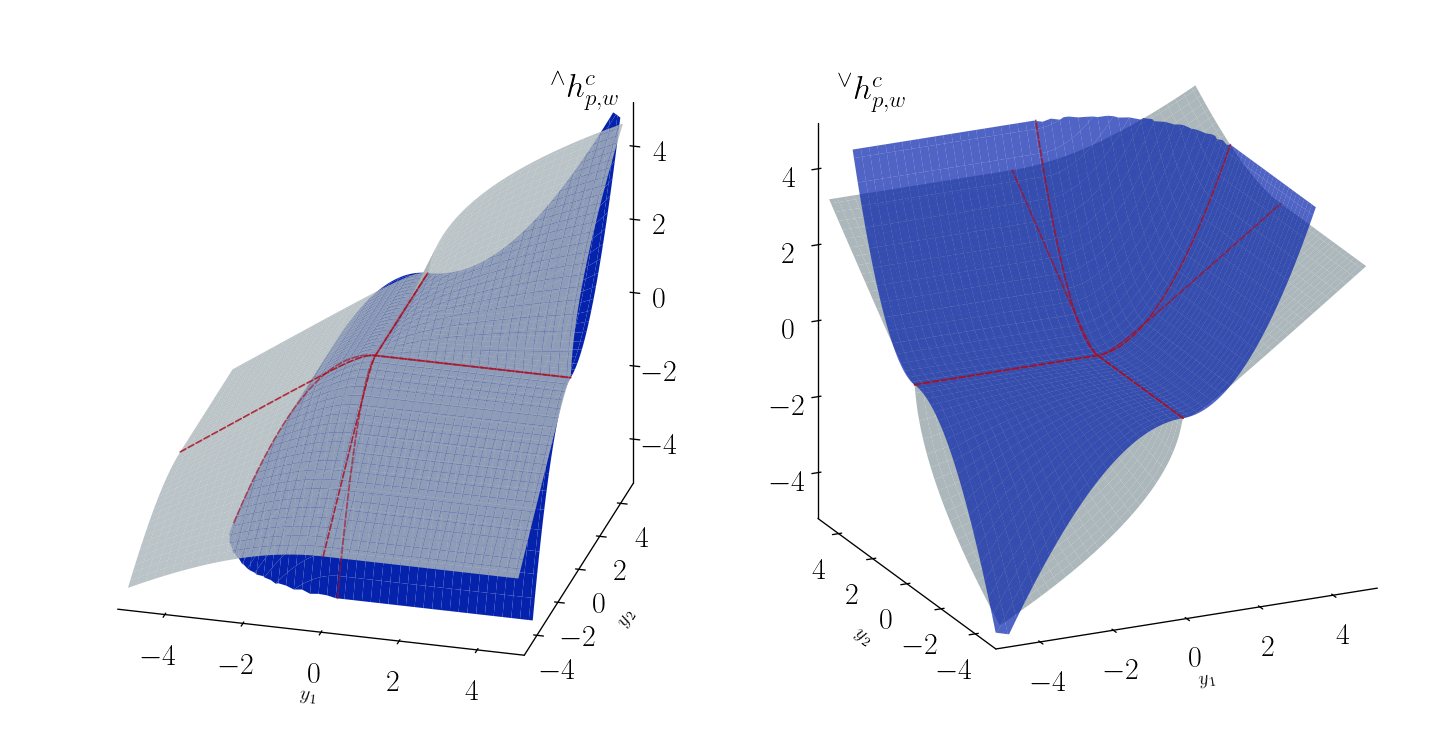

In [42]:
if 'plot_fcns' in run_list:
    plot_fcns()

## How it works?

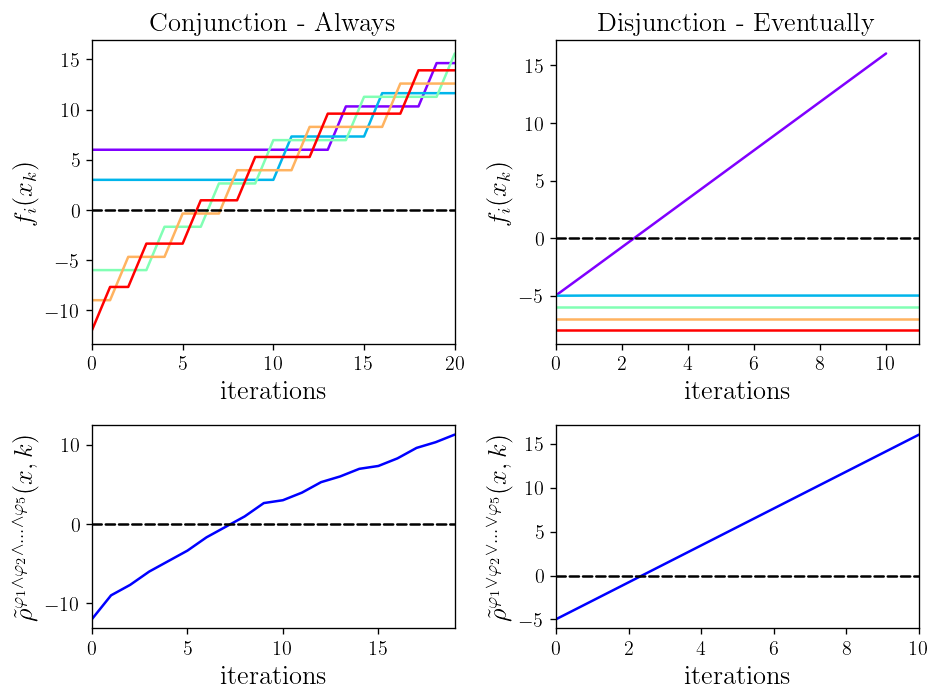

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

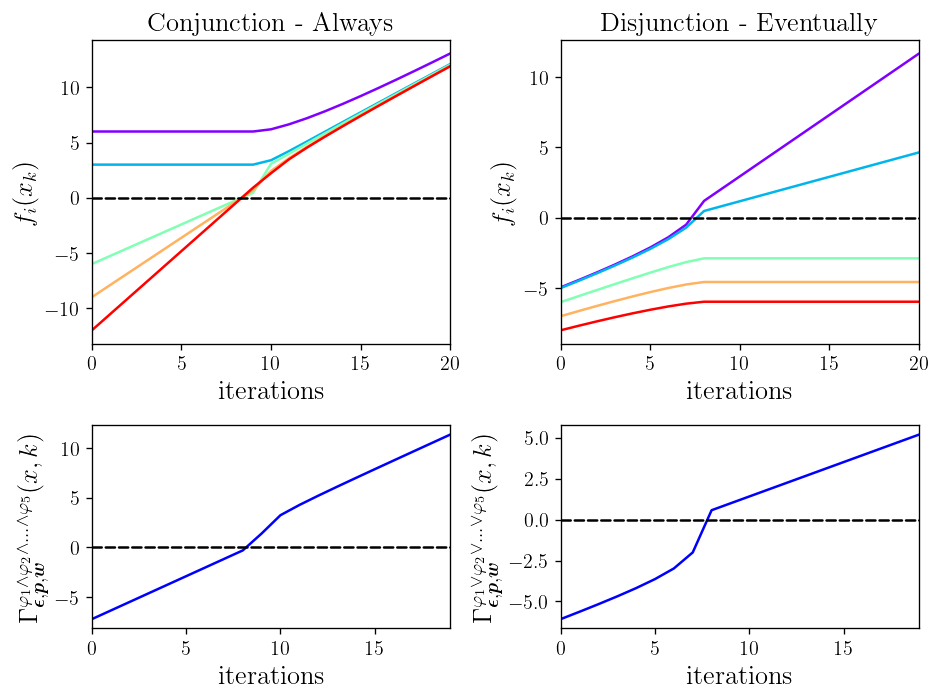

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

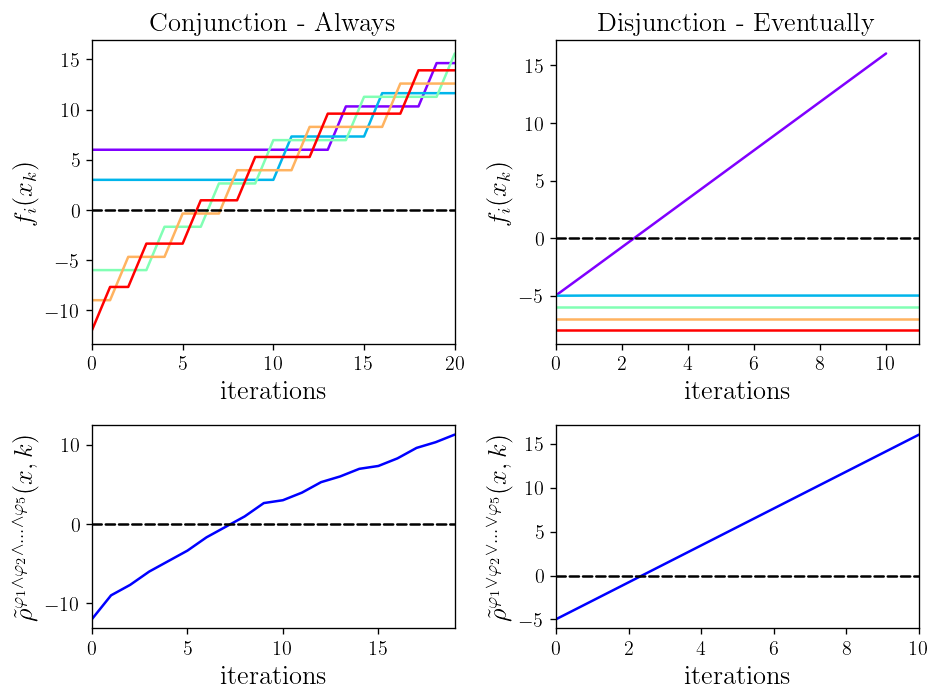

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

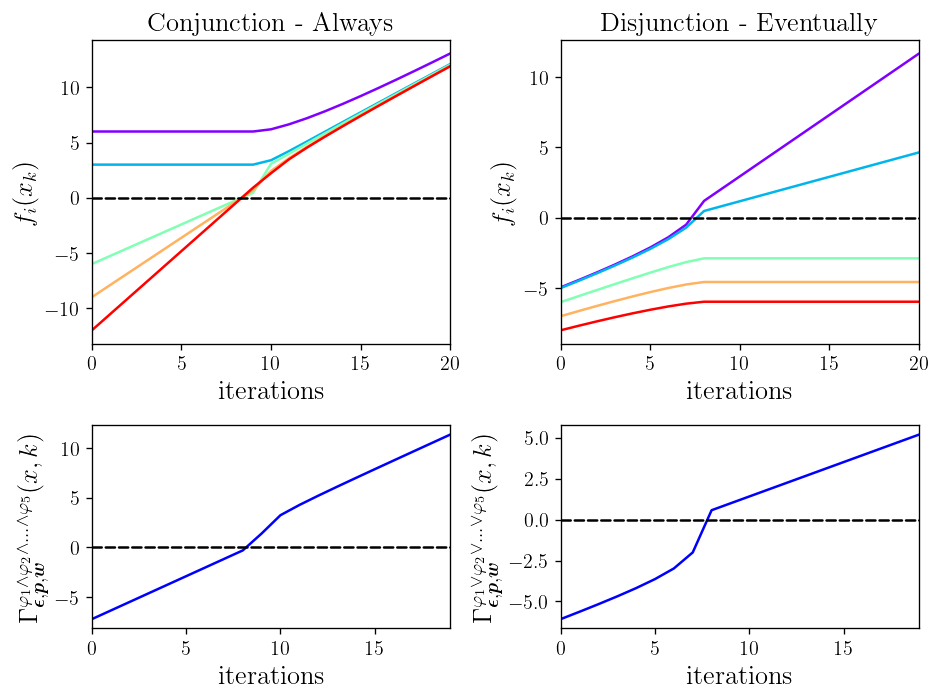

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

In [43]:
if 'how_it_works' in run_list:
    grad_des_on_ssr_dgmsr()
    grad_des_on_ssr_dgmsr()

## Locality \& Masking

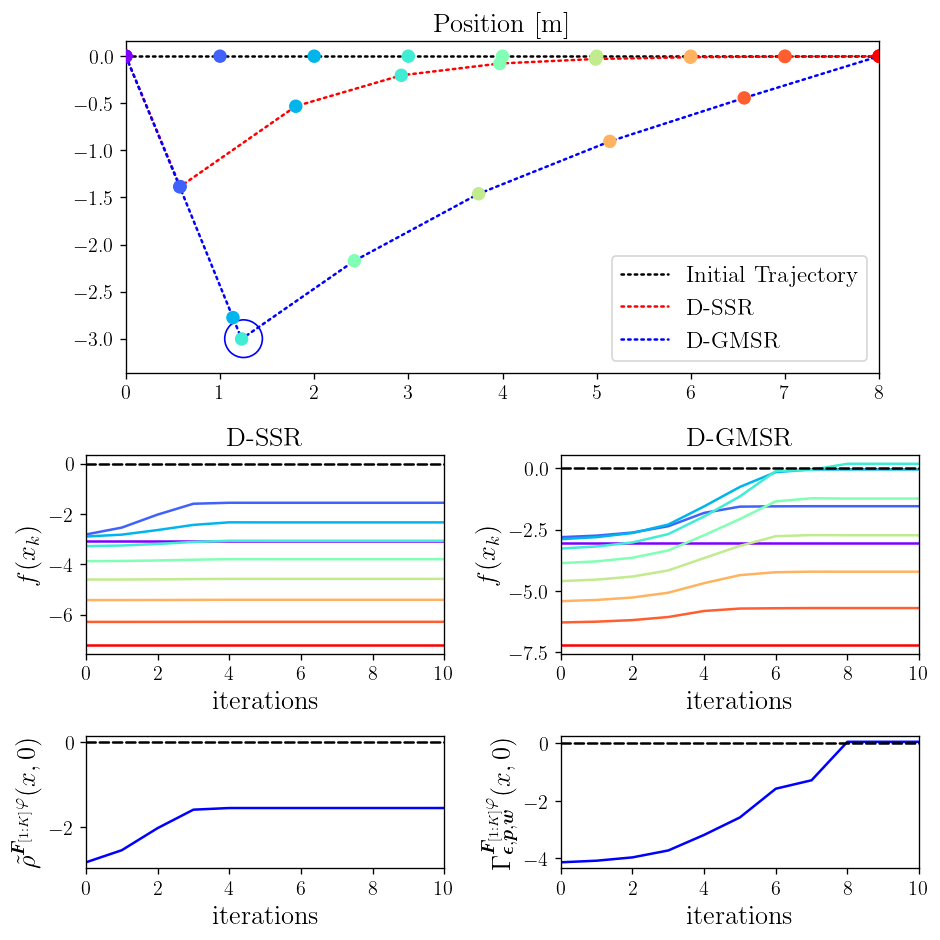

<Figure size 768x576 with 0 Axes>

In [44]:
if 'locality_masking' in run_list:
    lm_params = lm_params_fcn()
    RUN_LM(lm_params)

## Trajectory Optimization

### Nonlinear Double Integrator

100%|██████████| 16/16 [00:00<00:00, 4205.08it/s]


Dynamical Cost 1.2545432536298235e-08
STL Cost -0.053301970003109954
TR Weight 10.24


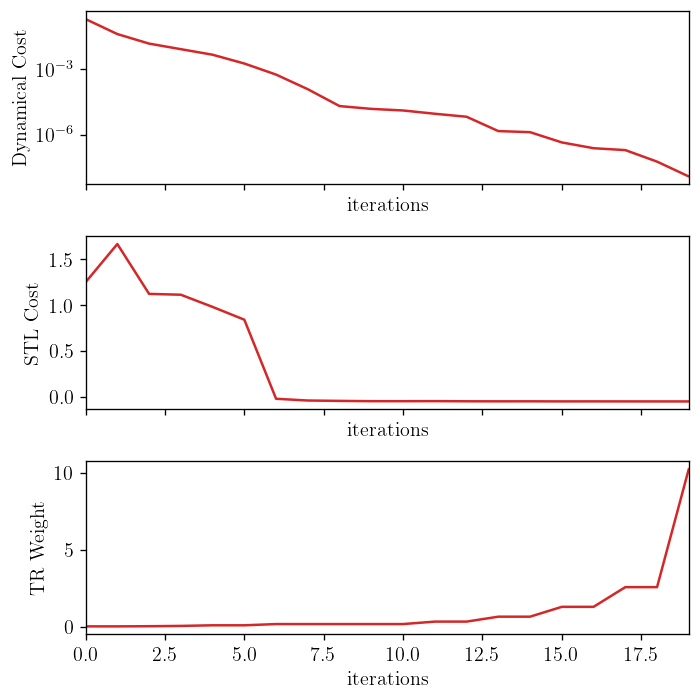

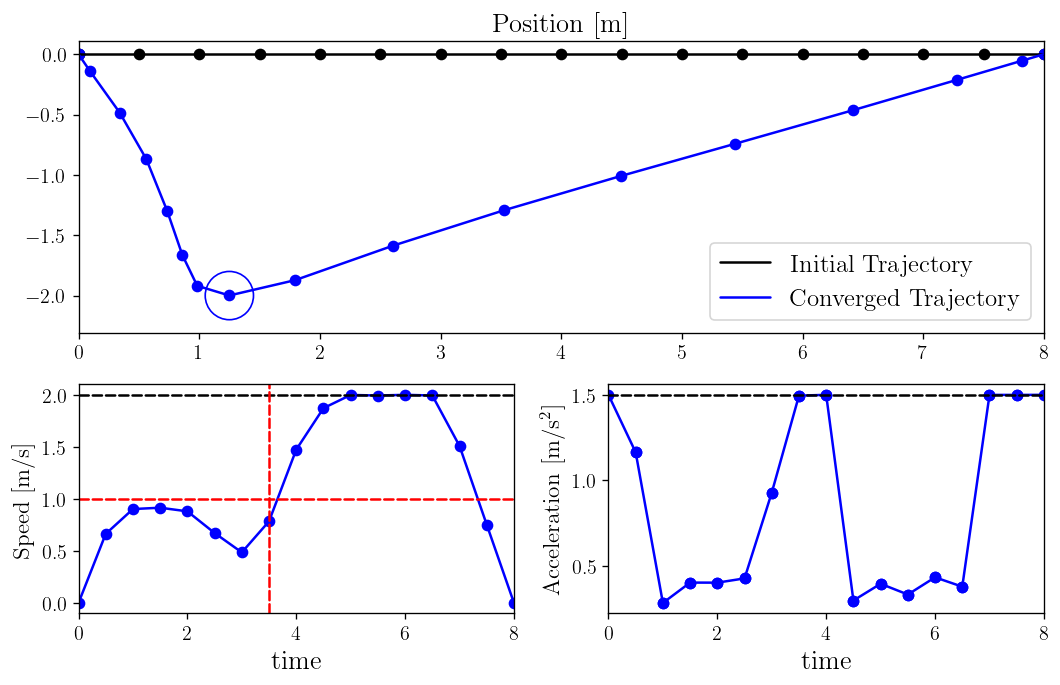

In [45]:
if 'run_nonlinear_double_integrator' in run_list:
    ndi_params0 = ndi_params_fcn()
    ndi_params = ndi_dynamics(ndi_params0.copy())
    ndi_params['vehicle_cost_fcn'] = ndi_cost_fcn
    ndi_params['vehicle_cons_fcn'] = ndi_cons_fcn

    ndi_results = RUN(ndi_params.copy())

    plot_cost(ndi_results, ndi_params, vehicle='ndi')
    ndi_plot(ndi_results, ndi_params)

### Quadrotor flight

100%|██████████| 100/100 [00:00<00:00, 2448.76it/s]


Dynamical Cost 9.639012183162018e-06
STL Cost -0.0784345779925467
TR Weight 1.28


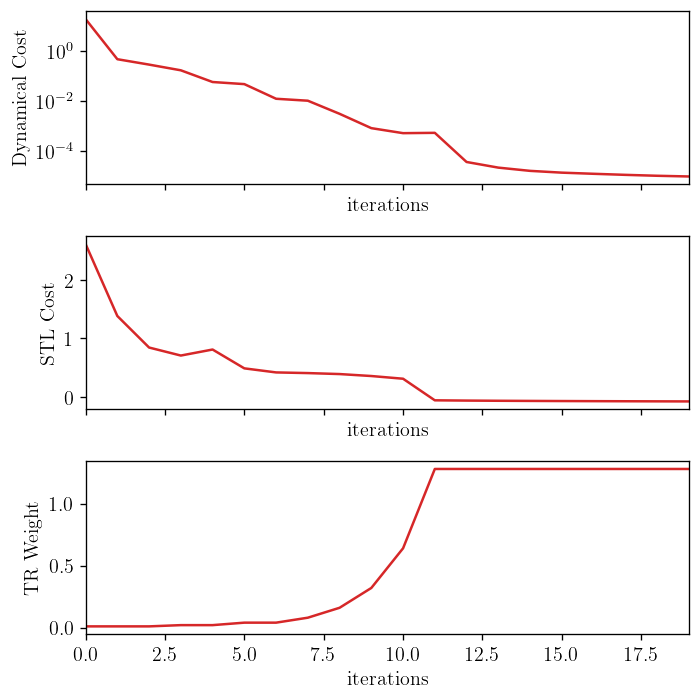

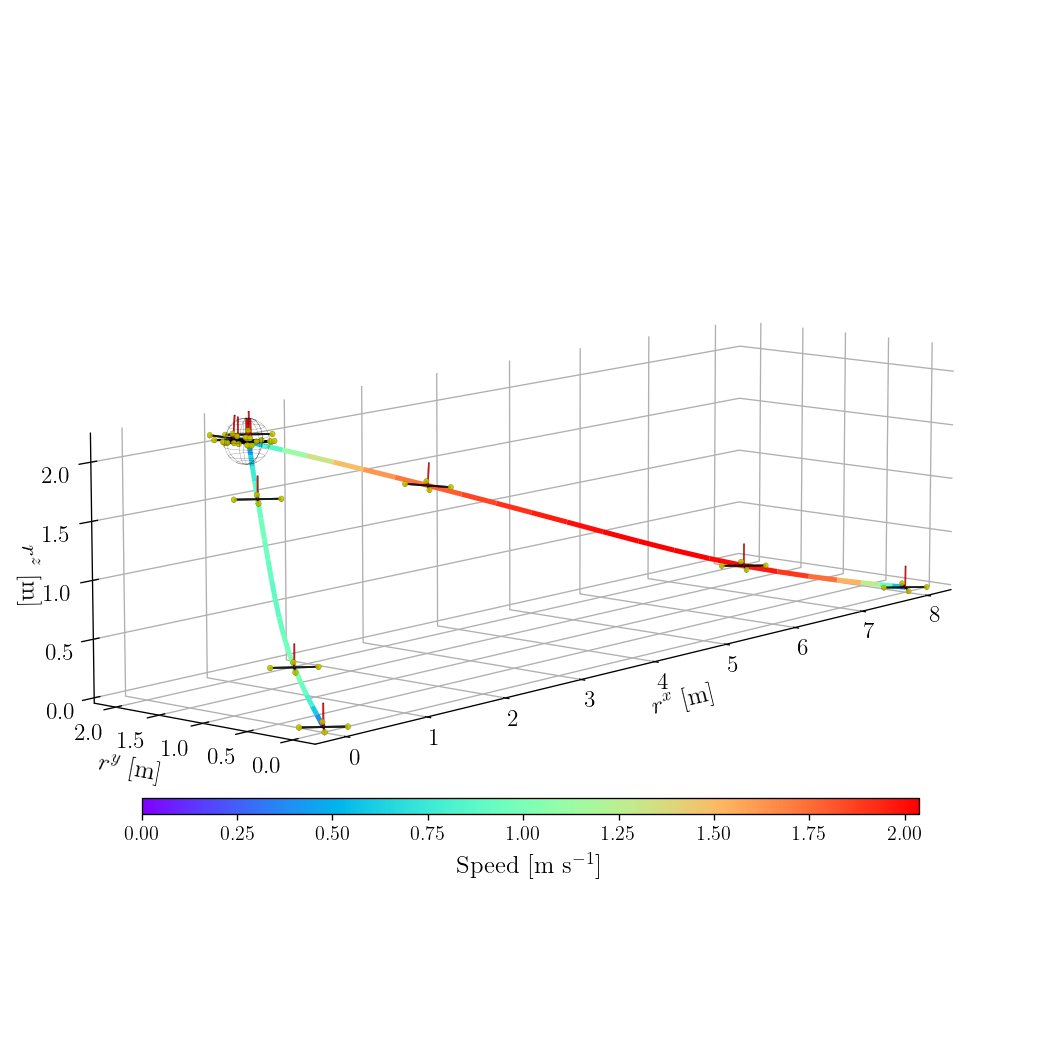

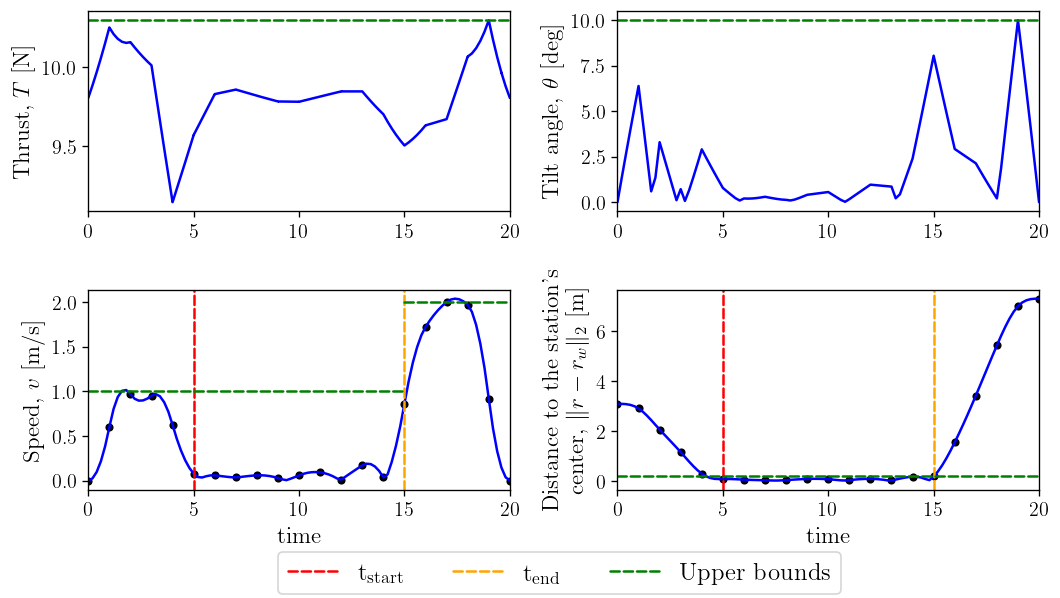

In [46]:
if 'run_quadrotor_flight' in run_list:
    qf_params0 = qf_params_fcn()
    qf_params = qf_dynamics(qf_params0.copy())
    qf_params['vehicle_cost_fcn'] = qf_cost_fcn
    qf_params['vehicle_cons_fcn'] = qf_cons_fcn

    qf_results = RUN(qf_params.copy())

    plot_cost(qf_results, qf_params, vehicle='qf')
    qf_plot(qf_results, qf_params)

### Autonomous Rocket Landing

100%|██████████| 200/200 [00:00<00:00, 1024.74it/s]


Dynamical Cost 1.1759680574695318e-05
STL Cost 6.322380841083941e-09
TR Weight 64.0


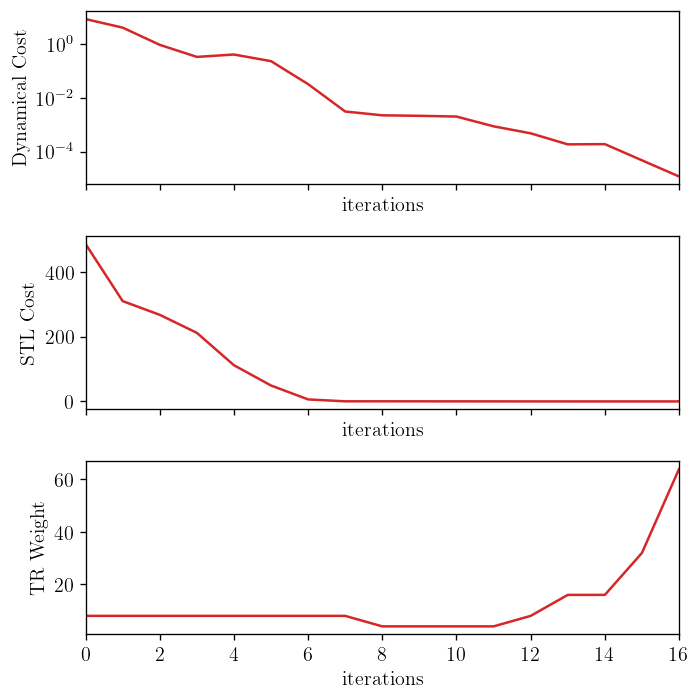

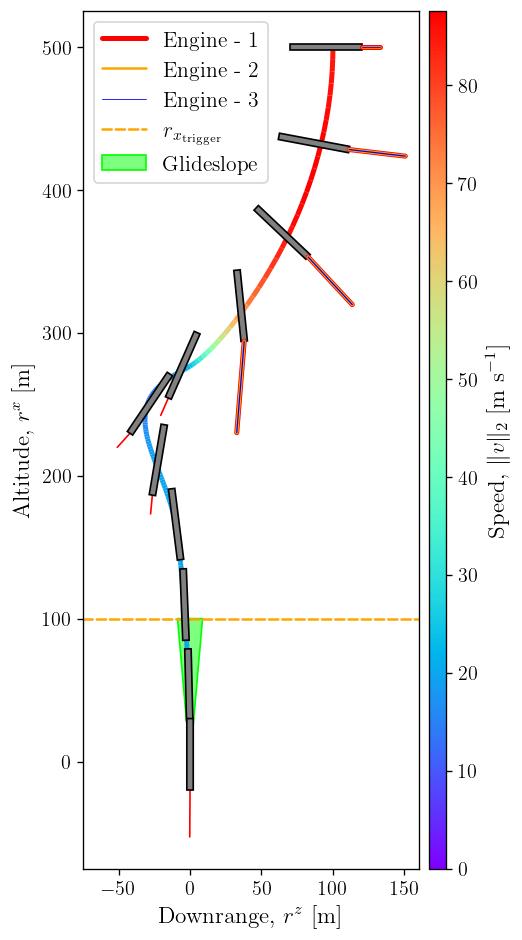

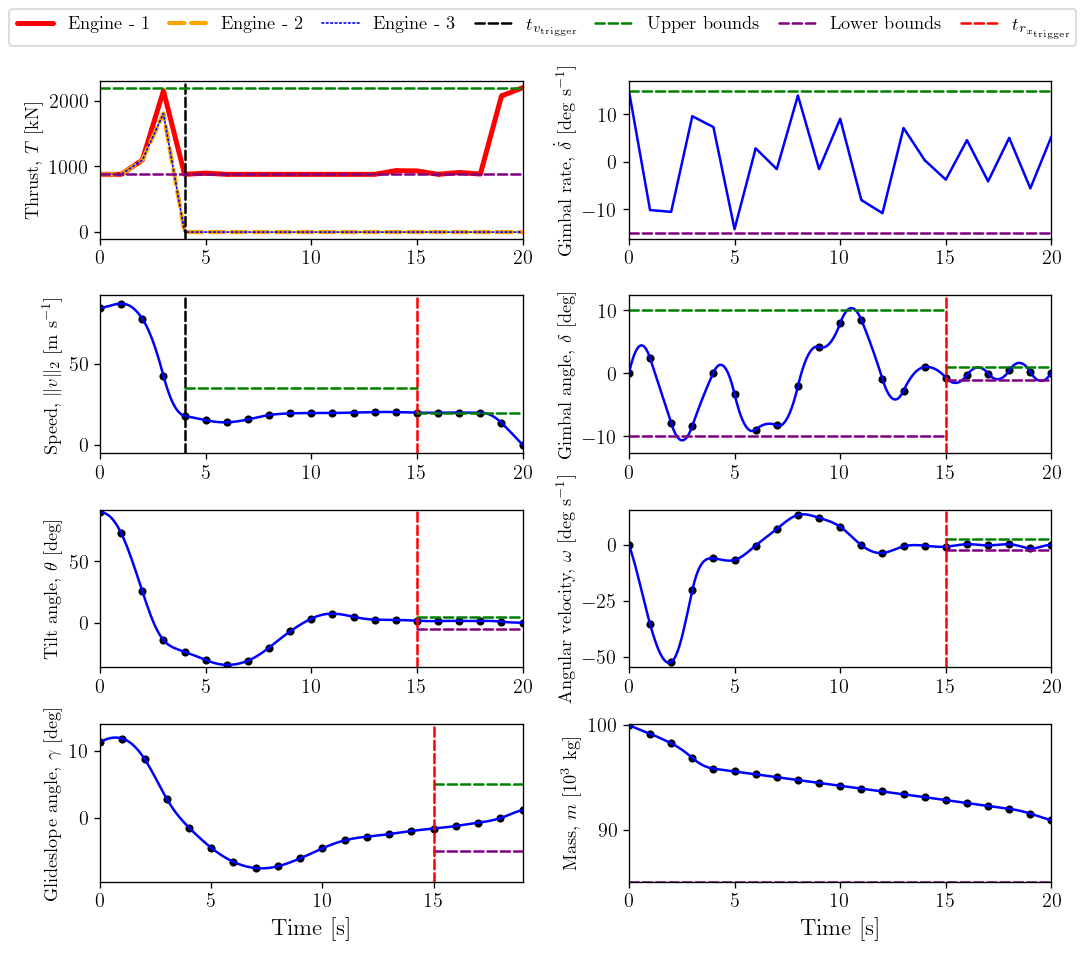

In [47]:
if 'run_rocket_landing' in run_list:
    rl_params = rl_params_fcn()
    rl_params_sc = scale_params(rl_params.copy())

    rl_params_sc = rl_dynamics(rl_params_sc.copy())
    rl_params_sc['vehicle_cost_fcn'] = rl_cost_fcn
    rl_params_sc['vehicle_cons_fcn'] = rl_cons_fcn

    rl_results_sc = RUN(rl_params_sc.copy())
    rl_results = unscale_results(rl_results_sc.copy(), rl_params.copy())

    plot_cost(rl_results, rl_params, vehicle='rl')
    rl_plot(rl_results, rl_params)
    if rl_animations: 
        make_gif('sim/')
